# Can We Predict The Star Type

With ML techniques, we can categorize the stars between dwarfs and giants stars.

* Tasks you can do:
1. Preprocess the Data
    - Clean the Data (Null values, Errored values)

    
    
2. Analysis and Predict Star Type
    - Try different models
    - Performing deep neural network and create a decision boundary

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  
    target_cell = this_cell  
    js_hide_current = ''

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

# 1. Process the Data 

#### Imporing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image, display
from PIL import Image
hide_toggle()

#### scikit-learn for models

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
hide_toggle()

#### Jupyter theme for black plots

In [4]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes import jtplot

#### Loading dataset

In [5]:
raw = pd.read_csv('../Star-Classification/Star99999_raw.csv')

#### Exploring dataset

In [6]:
raw.head()

Unnamed: 0   Vmag      Plx   e_Plx     B-V SpType
0           0   9.10     3.54    1.39   0.482     F5
1           1   9.27    21.90    3.10   0.999    K3V
2           2   6.61     2.81    0.63  -0.019     B9
3           3   8.06     7.75    0.97   0.370    F0V
4           4   8.55     2.87    1.11   0.902  G8III

#### Columns:

Vmag - Visual Apparent Magnitude of the Star (m)

Plx - Distance Between the Star and the Earth (d)

e_Plx - Standard Error of Plx

B-V - B-V color index. (A hot star has a B-V color index close to 0 or negative, while a cool star has a B-V color index close to 2.0. Other stars are somewhere in between.)

SpType - Stellar classification.

In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  99999 non-null  int64 
 1   Vmag        99999 non-null  object
 2   Plx         99999 non-null  object
 3   e_Plx       99999 non-null  object
 4   B-V         99999 non-null  object
 5   SpType      97377 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB


# - Data Cleaning

#### Unnamed: 0 is a index columns :

but we already have it so let's dropt it


In [8]:
raw.drop('Unnamed: 0', axis = 1, inplace = True)

raw.head()

Vmag      Plx   e_Plx     B-V SpType
0   9.10     3.54    1.39   0.482     F5
1   9.27    21.90    3.10   0.999    K3V
2   6.61     2.81    0.63  -0.019     B9
3   8.06     7.75    0.97   0.370    F0V
4   8.55     2.87    1.11   0.902  G8III

#### Let's change the columns name to better manipulation

In [9]:
raw.rename(columns={'B-V':'B_V'}, inplace = True)

In [10]:
raw.query('B_V == "      "')

Vmag      Plx   e_Plx     B_V   SpType
44      9.59    15.10    1.92          G6/G8V:
52     10.96    -1.76    2.45              NaN
319    12.14     6.48    4.13              F1:
374     9.08     6.13    1.59              NaN
389    11.67     4.86    2.61               F7
...      ...      ...     ...     ...      ...
99525   8.71                               NaN
99665   9.25     5.97    3.05              NaN
99701  10.46    23.91    1.78               K0
99770   9.53                               NaN
99915  10.51                               NaN

[1128 rows x 5 columns]

#### converting object type columns to numeric

In [11]:
raw.Vmag = pd.to_numeric(raw.Vmag, downcast='float', errors ='coerce')
raw.Plx = pd.to_numeric(raw.Plx, downcast='float', errors ='coerce')
#raw.e_Plx = pd.to_numeric(raw.e_Plx, downcast='float', errors ='coerce')
raw['B_V'] = pd.to_numeric(raw['B_V'], downcast='float', errors ='coerce')

In [12]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vmag    99998 non-null  float32
 1   Plx     99768 non-null  float32
 2   e_Plx   99999 non-null  object 
 3   B_V     98871 non-null  float32
 4   SpType  97377 non-null  object 
dtypes: float32(3), object(2)
memory usage: 2.7+ MB


In [13]:
raw.describe().T

count      mean        std        min    25%    50%    75%         max
Vmag  99998.0  8.369750   1.313896  -1.440000  7.640  8.440  9.140   14.080000
Plx   99768.0  7.212467  11.348988 -54.950001  2.510  4.630  8.410  772.330017
B_V   98871.0  0.704726   0.489679  -0.400000  0.348  0.612  1.075    5.460000

#### Checking for missing values

In [14]:
raw.isnull().sum()

Vmag         1
Plx        231
e_Plx        0
B_V       1128
SpType    2622
dtype: int64

In [15]:
raw.shape

(99999, 5)

#### What is the % of the missing data

In [16]:
total_cells = np.product(raw.shape)
total_missing = raw.isnull().sum().sum()
percent_missing = (total_missing/total_cells)* 100

In [17]:
print(f'Missing data equals: {round(percent_missing,2)}%' )

Missing data equals: 0.8%


#### Pourcentage insignificant, so lets drop those rows

In [18]:
raw_missing_removed = raw.dropna()

In [19]:
raw_missing_removed.shape

(96742, 5)

In [20]:
raw_missing_removed.isnull().sum()

Vmag      0
Plx       0
e_Plx     0
B_V       0
SpType    0
dtype: int64

#### How many rows did we dropped?

In [21]:
dropped_rows = raw.shape[0] - raw_missing_removed.shape[0]

In [22]:
print(f'We dropped : {dropped_rows} rows')

We dropped : 3257 rows


#### What is the pourcentage of this amount? 

In [23]:
pourcentage_dropped_rows = ((raw.shape[0] - raw_missing_removed.shape[0])/raw.shape[0])*100

In [24]:
print(f'Dropped rows equals : {round(pourcentage_dropped_rows,2)} %')

Dropped rows equals : 3.26 %


#### Checking for duplicated

In [25]:
raw_missing_removed.duplicated().sum()

0

#### But after dropping so many rows our index must be weird

#### Let's ReIndex it

In [26]:
raw_missing_removed.reset_index(drop=True, inplace = True)

In [27]:
raw_missing_removed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96742 entries, 0 to 96741
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vmag    96742 non-null  float32
 1   Plx     96742 non-null  float32
 2   e_Plx   96742 non-null  object 
 3   B_V     96742 non-null  float32
 4   SpType  96742 non-null  object 
dtypes: float32(3), object(2)
memory usage: 2.6+ MB


In [28]:
raw_missing_removed.describe().T

count      mean        std        min    25%    50%    75%         max
Vmag  96742.0  8.291918   1.247995  -1.440000  7.610  8.400  9.070   13.610000
Plx   96742.0  7.105242  11.145643 -35.099998  2.520  4.600  8.270  772.330017
B_V   96742.0  0.700663   0.490053  -0.400000  0.342  0.605  1.072    5.460000


## First Part Data Cleaned 

### Let's Find Some Features of the Stars

New Columns : 

Plx = Parallax Distance Between the Star and the Earth (arsec) 

Distance = Distance Between the Star and the Earth (parsec)

ly = Distance Between the Star and Earth (light years)

Amag = Absolute Magnitude of the Star (mag)

Temperature = Temperature Effective considering the star as a perfect black body (kelvin)

Luminosity = Star's luminosity (watts)

Luminosity(Sun=1) = Star's luminosity in the terms of the luminosity of the Sun (watts)

Mass(Sun=1) = Star's Mass in the terms of the Mass of the Sun (solar mass)

Radius(Sun) = Star's Radius in the terms of the Radius of the Sun (solar mass)

Radius = Star's Radius (meters)

#### Some Equations asks for log of Plx(d) (which is the distance between the star and the Earth)
#### But log of 0 is infinite and we can't use it

So let's not consider theses rows

In [29]:
# Seeing how many zeros we have in Plx

raw_missing_removed.query("Plx == 0")

Vmag  Plx   e_Plx    B_V    SpType
945     8.68  0.0    1.19  1.290     K2III
1413    7.63  0.0    0.77  0.267   B1II...
18219  10.09  0.0    1.84  0.190        A0
23867  10.75  0.0    1.21 -0.012         B
26477   9.01  0.0    1.40  0.089        B8
29457   8.44  0.0    1.26  0.042     B1Vne
29968   6.57  0.0    0.89  0.121     A0III
36969   7.90  0.0    0.99  1.745         S
37320   8.24  0.0    1.29  1.341        K0
39917   9.28  0.0    1.60  0.956         G
41869   8.87  0.0    1.22  1.638      M...
42858   9.20  0.0    1.15  0.293        A2
47633   9.18  0.0    1.12  1.004        G5
48636  10.95  0.0    1.67  0.272      A8.7
49573   9.36  0.0    0.86  0.010       B9V
49658   8.26  0.0    0.87  0.681      F2II
59357  10.97  0.0    2.21  0.184       A3V
61404   9.00  0.0    1.30  1.065     G8III
61695   8.00  0.0    0.88  1.576  K2II/III
62922   6.00  0.0    0.78  0.236    B0.5Ia
64666   8.94  0.0    1.31  0.110      B9IV
65552   5.83  0.0    0.84 -0.053    B2IIIe
66660   9.00  0.0    1.23  0.026    B8IV/V
75644   9.50  0.0    1.52  0.949        K0
77888  10.34  0.0    2.02  1.246        K0
83929   9.23  0.0    1.02  1.665        M0
84040   8.84  0.0    1.17  0.134        B8
85938   6.53  0.0    0.85 -0.059   B1/B2Ib
86937  10.29  0.0    2.36  0.169        A0
87228   6.61  0.0    1.14  0.778      B1Ia
88274   9.49  0.0    1.69  1.500        G1
88909   8.20  0.0    1.15  0.925    B0.5Ia
92075   6.99  0.0    0.98  1.022        C0
92710   9.15  0.0    1.47  1.631     K4III
93323  10.01  0.0    2.10  1.500   M6e-M8e

In [30]:
# Choosing only the rows with Plx different than zero

raw_missing_removed = raw_missing_removed.query('Plx != 0')

In [31]:
raw_missing_removed.shape

(96707, 5)

In [32]:
# Confirming that there is no more Plx zero left

raw_missing_removed.query('Plx == 0')

Empty DataFrame
Columns: [Vmag, Plx, e_Plx, B_V, SpType]
Index: []

In [33]:
# reindexing the dataframe

raw_missing_removed.reset_index(drop = True, inplace = True)

In [34]:
raw_missing_removed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96707 entries, 0 to 96706
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vmag    96707 non-null  float32
 1   Plx     96707 non-null  float32
 2   e_Plx   96707 non-null  object 
 3   B_V     96707 non-null  float32
 4   SpType  96707 non-null  object 
dtypes: float32(3), object(2)
memory usage: 2.6+ MB


In [35]:
raw_missing_removed.describe().T

count      mean        std        min    25%    50%    75%         max
Vmag  96707.0  8.291762   1.247954  -1.440000  7.610  8.400  9.070   13.610000
Plx   96707.0  7.107813  11.146737 -35.099998  2.520  4.600  8.270  772.330017
B_V   96707.0  0.700663   0.490001  -0.400000  0.342  0.605  1.072    5.460000

In [36]:
# assigning the actual dataframe to simpler variable for better manipulation
df = raw_missing_removed.copy()


#### The Plx is in Milliarcsecond (mas) and we need it in arcsecond (arsec)

#### 1 mas = 0.00099999995874704 arcsec.


#### 1 pc = 1 arsecs (arcsecond)


In [37]:
# converting to arsec

df['Plx'] = df.Plx.map(lambda x : x*0.00099999995874704)

In [38]:
df.describe().T

count      mean       std     min      25%     50%      75%       max
Vmag  96707.0  8.291762  1.247954 -1.4400  7.61000  8.4000  9.07000  13.61000
Plx   96707.0  0.007108  0.011147 -0.0351  0.00252  0.0046  0.00827   0.77233
B_V   96707.0  0.700663  0.490001 -0.4000  0.34200  0.6050  1.07200   5.46000


#### we can get the distance in light years to faciliate the reading later

#### to get the light years we need to get the distance modulus from its Plx 


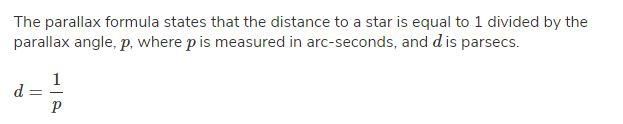

In [39]:
display(Image.open('../Star-Classification/Distance_by_Plx.JPG'))

In [40]:
# getting te distance modulus
df['Distance'] = df.Plx.map(lambda x : 1/x)

#### 1 parsecs = 3.26 light lyears

In [41]:
# converting the distance parsec in light years
df['ly'] = df['Distance'].map(lambda x : (abs(x)*3.26))

In [42]:
df.describe().T

count         mean           std            min         25%  \
Vmag      96707.0     8.291762      1.247954      -1.440000    7.610000   
Plx       96707.0     0.007108      0.011147      -0.035100    0.002520   
B_V       96707.0     0.700663      0.490001      -0.400000    0.342000   
Distance  96707.0   286.335567   3292.193462 -100000.006360  109.890110   
ly        96707.0  1952.241255  10594.701704       4.220994  393.244891   

                 50%          75%            max  
Vmag        8.400000     9.070000      13.610000  
Plx         0.004600     0.008270       0.772330  
B_V         0.605000     1.072000       5.460000  
Distance  202.429156   361.010848  100000.006360  
ly        705.627752  1278.431449  326000.020735

#### Getting Amag (Absolute Magnitude)

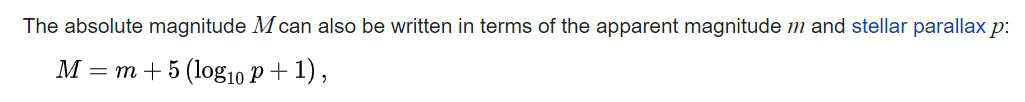

In [43]:
display(Image.open('../Star-Classification/Amag.JPG'))

In [44]:
# getting Absolute Maagnitude

df['Amag'] = df.Vmag + 5 *(np.log10(((df.Plx)))+1)

C:\Users\bruna\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
df.describe().T

count         mean           std            min         25%  \
Vmag      96707.0     8.291762      1.247954      -1.440000    7.610000   
Plx       96707.0     0.007108      0.011147      -0.035100    0.002520   
B_V       96707.0     0.700663      0.490001      -0.400000    0.342000   
Distance  96707.0   286.335567   3292.193462 -100000.006360  109.890110   
ly        96707.0  1952.241255  10594.701704       4.220994  393.244891   
Amag      93556.0     1.599608      2.326055     -13.310000    0.263157   

                 50%          75%            max  
Vmag        8.400000     9.070000      13.610000  
Plx         0.004600     0.008270       0.772330  
B_V         0.605000     1.072000       5.460000  
Distance  202.429156   361.010848  100000.006360  
ly        705.627752  1278.431449  326000.020735  
Amag        1.511542     3.064660      15.449015

#### Getting Temperature Effective from B-V



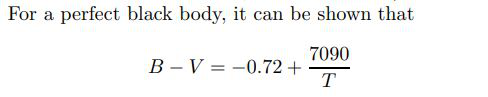

In [46]:
display(Image.open('../Star-Classification/temperature.JPG'))


In [47]:
df['Temperature'] = 7090/(df.B_V + 0.72)



#### Let's calculate luminosity


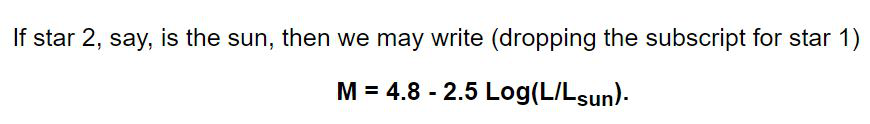

In [48]:
display(Image.open('../Star-Classification/Luminosity.JPG'))


In [49]:
# getting luminosity by the sun luminosity (3.828e+26)

df['Luminosity'] = df.Amag.map(lambda x: 3.828e+26/10**((x-4.8)/2.5))

In [50]:
# considering sun luminosity = 1

df['Luminosity(Sun=1)'] = df.Amag.map(lambda x: 1/10**((x-4.8)/2.5))

#### Getting the Stars Mass


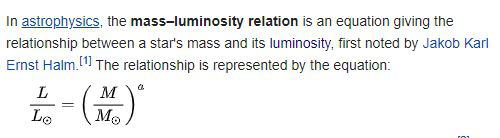

In [51]:
display(Image.open('../Star-Classification/Mass_Luminosity.JPG'))

In [52]:
# getting mass from sun mass and luminosity = 1 

df['Mass(Sun=1)'] = df['Luminosity(Sun=1)']**2/7

#### Let's get Star Radius

Radius sun = 7.35355×10−8 light-year /2.25461×10−8	parsec

Tem sun = 5.778 K

Lum sun = 3.828×e+1026 watts

In [53]:
# we can get the star radius from the sun real values:

df['Radius(sun)'] = df.Luminosity* 7.35355e-8*5.778/3.828e+26*df.Temperature

In [54]:
# we can algo get the radius from it's luminosity and temperature

df['Radius'] = 1181.57*np.sqrt(df.Luminosity) / df.Temperature

In [55]:
df.describe().T

count          mean           std           min  \
Vmag               96707.0  8.291762e+00  1.247954e+00 -1.440000e+00   
Plx                96707.0  7.107773e-03  1.114689e-02 -3.510000e-02   
B_V                96707.0  7.006627e-01  4.900010e-01 -4.000000e-01   
Distance           96707.0  2.863356e+02  3.292193e+03 -1.000000e+05   
ly                 96707.0  1.952241e+03  1.059470e+04  4.220994e+00   
Amag               93556.0  1.599608e+00  2.326055e+00 -1.331000e+01   
Temperature        96707.0  5.685351e+03  2.187985e+03  1.147249e+03   
Luminosity         93556.0  8.568882e+29  3.791047e+31  2.105552e+22   
Luminosity(Sun=1)  93556.0  2.238475e+03  9.903467e+04  5.500398e-05   
Mass(Sun=1)        93556.0  1.401825e+09  1.774229e+11  4.322054e-10   
Radius(sun)        93556.0  5.820296e+00  3.102057e+02  6.557068e-08   
Radius             93556.0  4.571646e+13  2.544964e+14  5.604521e+10   

                            25%           50%           75%           max  
Vmag               7.610000e+00  8.400000e+00  9.070000e+00  1.361000e+01  
Plx                2.520000e-03  4.600000e-03  8.270000e-03  7.723300e-01  
B_V                3.420000e-01  6.050000e-01  1.072000e+00  5.460000e+00  
Distance           1.098901e+02  2.024292e+02  3.610108e+02  1.000000e+05  
ly                 3.932449e+02  7.056278e+02  1.278431e+03  3.260000e+05  
Amag               2.631575e-01  1.511542e+00  3.064660e+00  1.544901e+01  
Temperature        3.956473e+03  5.350943e+03  6.676083e+03  2.215625e+04  
Luminosity         1.892813e+27  7.913258e+27  2.498670e+28  6.713855e+33  
Luminosity(Sun=1)  4.944654e+00  2.067204e+01  6.527352e+01  1.753881e+07  
Mass(Sun=1)        3.492800e+00  6.104762e+01  6.086617e+02  4.394425e+13  
Radius(sun)        1.194030e-02  4.652123e-02  1.441366e-01  6.680848e+04  
Radius             8.654484e+12  1.688555e+13  3.869577e+13  2.834827e+16

### Display Star Classification

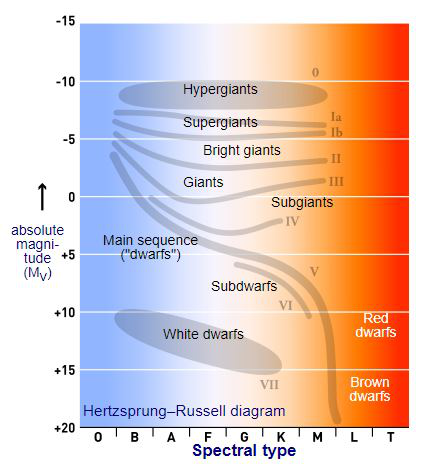

In [56]:
display(Image.open('../Star-Classification/Star_Classification.JPG'))

#### We can see the main sequence (dwarfs) stars can have same absolute magnitude as giants ones
#### that means they can have other similiars properties

# - Create a label column via SpType

In [57]:
def label_gen_stars(star):
    dwarf = ['D','VI', 'VII', 'V']
    giant = ['IV', 'III', 'II', 'Ib', 'Ia', 'Ia-O']
    for i in dwarf :
        if i in star:
            return 'Dwarf'
    for i in giant:
        if i in star:
            return 'Giant'
    return 'Other'
    

In [58]:
df['Star_Type'] = df.SpType.apply(label_gen_stars)

#### We want to predict dwarf and giants stars ( we can desconsider other type)


In [59]:
df.Star_Type.value_counts()

Other    49196
Dwarf    27752
Giant    19759
Name: Star_Type, dtype: int64

In [60]:

df = df.query('Star_Type != "Other"')

df.query('Star_Type == "Other"')

df.Star_Type.value_counts()

Dwarf    27752
Giant    19759
Name: Star_Type, dtype: int64

## Data Cleaning

### Dropping rows that are null

In [61]:
df.isnull().sum()

Vmag                    0
Plx                     0
e_Plx                   0
B_V                     0
SpType                  0
Distance                0
ly                      0
Amag                 1256
Temperature             0
Luminosity           1256
Luminosity(Sun=1)    1256
Mass(Sun=1)          1256
Radius(sun)          1256
Radius               1256
Star_Type               0
dtype: int64

In [62]:
df_clean = df.dropna()

In [63]:
print(f'We dropped : {df.shape[0] - df.dropna().shape[0]} rows')


We dropped : 1256 rows


In [64]:
df_clean.isnull().sum()

Vmag                 0
Plx                  0
e_Plx                0
B_V                  0
SpType               0
Distance             0
ly                   0
Amag                 0
Temperature          0
Luminosity           0
Luminosity(Sun=1)    0
Mass(Sun=1)          0
Radius(sun)          0
Radius               0
Star_Type            0
dtype: int64

In [65]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46255 entries, 1 to 96705
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Vmag               46255 non-null  float32
 1   Plx                46255 non-null  float64
 2   e_Plx              46255 non-null  object 
 3   B_V                46255 non-null  float32
 4   SpType             46255 non-null  object 
 5   Distance           46255 non-null  float64
 6   ly                 46255 non-null  float64
 7   Amag               46255 non-null  float64
 8   Temperature        46255 non-null  float64
 9   Luminosity         46255 non-null  float64
 10  Luminosity(Sun=1)  46255 non-null  float64
 11  Mass(Sun=1)        46255 non-null  float64
 12  Radius(sun)        46255 non-null  float64
 13  Radius             46255 non-null  float64
 14  Star_Type          46255 non-null  object 
dtypes: float32(2), float64(10), object(3)
memory usage: 5.3+ MB


### Are there any outliers?

In [66]:
summary = df_clean.describe().T


In [67]:

summary['IQR']=summary['75%']-summary['25%']
summary.head()

summary['IQR']=summary['75%']-summary['25%']
summary

count          mean           std           min  \
Vmag               46255.0  7.939283e+00  1.313916e+00 -6.200000e-01   
Plx                46255.0  7.883509e-03  1.268879e-02  9.999999e-06   
B_V                46255.0  6.919513e-01  4.980702e-01 -4.000000e-01   
Distance           46255.0  4.599750e+02  2.468987e+03  1.294783e+00   
ly                 46255.0  1.499519e+03  8.048899e+03  4.220994e+00   
Amag               46255.0  1.358017e+00  2.338901e+00 -1.306485e+01   
Temperature        46255.0  5.790804e+03  2.362701e+03  1.704327e+03   
Luminosity         46255.0  1.088042e+30  3.983179e+31  2.105552e+22   
Luminosity(Sun=1)  46255.0  2.842326e+03  1.040538e+05  5.500398e-05   
Mass(Sun=1)        46255.0  1.547862e+09  1.451541e+11  4.322054e-10   
Radius(sun)        46255.0  7.945451e+00  3.922793e+02  6.557068e-08   
Radius             46255.0  5.107660e+13  2.782541e+14  5.604521e+10   

                            25%           50%           75%           max  \
Vmag               7.220000e+00  8.180000e+00  8.850000e+00  1.279000e+01   
Plx                2.730000e-03  4.960000e-03  9.050000e-03  7.723300e-01   
B_V                3.230000e-01  6.170000e-01  1.074000e+00  3.440000e+00   
Distance           1.104972e+02  2.016129e+02  3.663004e+02  1.000000e+05   
ly                 3.602210e+02  6.572581e+02  1.194139e+03  3.260000e+05   
Amag               1.417298e-02  1.259997e+00  2.907844e+00  1.544901e+01   
Temperature        3.952062e+03  5.302917e+03  6.797699e+03  2.215625e+04   
Luminosity         2.186926e+27  9.976388e+27  3.142699e+28  5.356882e+33   
Luminosity(Sun=1)  5.712974e+00  2.606162e+01  8.209767e+01  1.399394e+07   
Mass(Sun=1)        4.662582e+00  9.702971e+01  9.628610e+02  2.797578e+13   
Radius(sun)        1.364917e-02  5.623171e-02  1.832988e-01  6.680848e+04   
Radius             9.213312e+12  1.950777e+13  4.249690e+13  2.190760e+16   

                            IQR  
Vmag               1.630001e+00  
Plx                6.320000e-03  
B_V                7.510000e-01  
Distance           2.558031e+02  
ly                 8.339182e+02  
Amag               2.893671e+00  
Temperature        2.845636e+03  
Luminosity         2.924006e+28  
Luminosity(Sun=1)  7.638469e+01  
Mass(Sun=1)        9.581984e+02  
Radius(sun)        1.696496e-01  
Radius             3.328359e+13

In [68]:
# The outliners

summary['cutoff']=round(summary.IQR*1.6, 3)
summary.head()

count         mean          std       min         25%         50%  \
Vmag      46255.0     7.939283     1.313916 -0.620000    7.220000    8.180000   
Plx       46255.0     0.007884     0.012689  0.000010    0.002730    0.004960   
B_V       46255.0     0.691951     0.498070 -0.400000    0.323000    0.617000   
Distance  46255.0   459.975018  2468.987387  1.294783  110.497240  201.612910   
ly        46255.0  1499.518558  8048.898880  4.220994  360.221002  657.258087   

                  75%            max         IQR    cutoff  
Vmag         8.850000      12.790000    1.630001     2.608  
Plx          0.009050       0.772330    0.006320     0.010  
B_V          1.074000       3.440000    0.751000     1.202  
Distance   366.300379  100000.006360  255.803139   409.285  
ly        1194.139235  326000.020735  833.918233  1334.269

In [69]:

summary['lw']=round(summary['25%']-summary.cutoff, 3)
summary['rw']=round(summary['75%']+summary.cutoff, 3)
summary.head()

count         mean          std       min         25%         50%  \
Vmag      46255.0     7.939283     1.313916 -0.620000    7.220000    8.180000   
Plx       46255.0     0.007884     0.012689  0.000010    0.002730    0.004960   
B_V       46255.0     0.691951     0.498070 -0.400000    0.323000    0.617000   
Distance  46255.0   459.975018  2468.987387  1.294783  110.497240  201.612910   
ly        46255.0  1499.518558  8048.898880  4.220994  360.221002  657.258087   

                  75%            max         IQR    cutoff       lw        rw  
Vmag         8.850000      12.790000    1.630001     2.608    4.612    11.458  
Plx          0.009050       0.772330    0.006320     0.010   -0.007     0.019  
B_V          1.074000       3.440000    0.751000     1.202   -0.879     2.276  
Distance   366.300379  100000.006360  255.803139   409.285 -298.788   775.585  
ly        1194.139235  326000.020735  833.918233  1334.269 -974.048  2528.408

In [70]:


# create a df with outliers
outliers=pd.DataFrame(columns=df_clean.columns)

#loop to detect outliers in each column
for col in summary.index:
    lower=summary.at[col,'lw'] #get lower whisker for this column
    upper=summary.at[col,'rw'] #get upper whisker for this column
    results=df_clean[(df_clean[col]<lower)|
        (df_clean[col]>upper)].copy() #get the dataframe
    results['Outlier']=col #to be able to identify in which column we obtained outliers
    outliers=outliers.append(results) #save them

outliers.shape



(44530, 16)

In [71]:
df_clean.shape

(46255, 15)

In [72]:
df = df_clean.drop(outliers.index)
print('Shape after dropping changed:', df.shape)


df.describe().T

Shape after dropping changed: (33548, 15)


count          mean           std           min  \
Vmag               33548.0  8.173058e+00  1.075288e+00  4.620000e+00   
Plx                33548.0  6.586774e-03  3.988240e-03  1.290000e-03   
B_V                33548.0  6.824287e-01  4.369864e-01 -9.500000e-02   
Distance           33548.0  2.182004e+02  1.360565e+02  5.263158e+01   
ly                 33548.0  7.113332e+02  4.435442e+02  1.715790e+02   
Amag               33548.0  1.875778e+00  1.452299e+00 -5.026097e-01   
Temperature        33548.0  5.622206e+03  1.933373e+03  2.381592e+03   
Luminosity         33548.0  1.113543e+28  1.138337e+28  3.340052e+25   
Luminosity(Sun=1)  33548.0  2.908943e+01  2.973713e+01  8.725320e-02   
Mass(Sun=1)        33548.0  2.472094e+02  4.388598e+02  1.087589e-03   
Radius(sun)        33548.0  6.729646e-02  7.673876e-02  1.400768e-04   
Radius             33548.0  2.242376e+13  1.761468e+13  1.266640e+12   

                            25%           50%           75%           max  
Vmag               7.570000e+00  8.340000e+00  8.930000e+00  1.144000e+01  
Plx                3.480000e-03  5.520000e-03  8.770000e-03  1.900000e-02  
B_V                3.780000e-01  5.990000e-01  1.038000e+00  2.257000e+00  
Distance           1.140251e+02  1.811594e+02  2.873563e+02  7.751939e+02  
ly                 3.717218e+02  5.905797e+02  9.367816e+02  2.527132e+03  
Amag               7.097275e-01  1.624298e+00  2.964798e+00  7.448047e+00  
Temperature        4.032992e+03  5.375284e+03  6.457195e+03  1.134400e+04  
Luminosity         2.075165e+27  7.132681e+27  1.656078e+28  5.058431e+28  
Luminosity(Sun=1)  5.421017e+00  1.863292e+01  4.326224e+01  1.321429e+02  
Mass(Sun=1)        4.198204e+00  4.959794e+01  2.673745e+02  2.494536e+03  
Radius(sun)        1.295333e-02  4.121113e-02  9.281310e-02  4.539501e-01  
Radius             9.048184e+12  1.564530e+13  3.215454e+13  9.380191e+13

#### Let's reindex

In [73]:
df.reset_index(drop=True, inplace=True)


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33548 entries, 0 to 33547
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Vmag               33548 non-null  float32
 1   Plx                33548 non-null  float64
 2   e_Plx              33548 non-null  object 
 3   B_V                33548 non-null  float32
 4   SpType             33548 non-null  object 
 5   Distance           33548 non-null  float64
 6   ly                 33548 non-null  float64
 7   Amag               33548 non-null  float64
 8   Temperature        33548 non-null  float64
 9   Luminosity         33548 non-null  float64
 10  Luminosity(Sun=1)  33548 non-null  float64
 11  Mass(Sun=1)        33548 non-null  float64
 12  Radius(sun)        33548 non-null  float64
 13  Radius             33548 non-null  float64
 14  Star_Type          33548 non-null  object 
dtypes: float32(2), float64(10), object(3)
memory usage: 3.6+ MB


### Let's find the spectral color type

O Be A Fine Girl (or Guy), Kiss Me!

In [75]:
df_clean.loc[df_clean.B_V <= -0.33, 'Color_Type'] ='O'
df_clean.loc[(df_clean.B_V > -0.33 ) & (df_clean.B_V < -0.02) , 'Color_Type'] ='B'
df_clean.loc[(df_clean.B_V >= -0.02) & (df_clean.B_V < 0.3) , 'Color_Type'] ='A'
df_clean.loc[(df_clean.B_V >= 0.3) & (df_clean.B_V < 0.58) , 'Color_Type'] ='F'
df_clean.loc[(df_clean.B_V >= 0.58) & (df_clean.B_V < 0.81) , 'Color_Type'] ='G'
df_clean.loc[(df_clean.B_V >= 0.81) & (df_clean.B_V < 1.4 ) , 'Color_Type'] ='K'
df_clean.loc[df_clean.B_V >= 1.4,  'Color_Type'] ='M'

In [76]:
df.loc[df.B_V <= -0.33, 'Color_Type'] ='O'
df.loc[(df.B_V > -0.33 ) & (df.B_V < -0.02) , 'Color_Type'] ='B'
df.loc[(df.B_V >= -0.02) & (df.B_V < 0.3) , 'Color_Type'] ='A'
df.loc[(df.B_V >= 0.3) & (df.B_V < 0.58) , 'Color_Type'] ='F'
df.loc[(df.B_V >= 0.58) & (df.B_V < 0.81) , 'Color_Type'] ='G'
df.loc[(df.B_V >= 0.81) & (df.B_V < 1.4 ) , 'Color_Type'] ='K'
df.loc[df.B_V >= 1.4,  'Color_Type'] ='M'

In [77]:
df.describe()

Vmag           Plx           B_V      Distance            ly  \
count  33548.000000  33548.000000  33548.000000  33548.000000  33548.000000   
mean       8.173058      0.006587      0.682429    218.200378    711.333232   
std        1.075288      0.003988      0.436986    136.056498    443.544183   
min        4.620000      0.001290     -0.095000     52.631581    171.578954   
25%        7.570000      0.003480      0.378000    114.025084    371.721775   
50%        8.340000      0.005520      0.599000    181.159428    590.579737   
75%        8.930000      0.008770      1.038000    287.356332    936.781643   
max       11.440000      0.019000      2.257000    775.193853   2527.131962   

               Amag   Temperature    Luminosity  Luminosity(Sun=1)  \
count  33548.000000  33548.000000  3.354800e+04       33548.000000   
mean       1.875778   5622.205573  1.113543e+28          29.089431   
std        1.452299   1933.373151  1.138337e+28          29.737132   
min       -0.502610   2381.592231  3.340052e+25           0.087253   
25%        0.709728   4032.992065  2.075165e+27           5.421017   
50%        1.624298   5375.284400  7.132681e+27          18.632917   
75%        2.964798   6457.194952  1.656078e+28          43.262238   
max        7.448047  11343.999978  5.058431e+28         132.142915   

        Mass(Sun=1)   Radius(sun)        Radius  
count  33548.000000  33548.000000  3.354800e+04  
mean     247.209380      0.067296  2.242376e+13  
std      438.859827      0.076739  1.761468e+13  
min        0.001088      0.000140  1.266640e+12  
25%        4.198204      0.012953  9.048184e+12  
50%       49.597941      0.041211  1.564530e+13  
75%      267.374462      0.092813  3.215454e+13  
max     2494.535725      0.453950  9.380191e+13

In [78]:
df_clean.describe()

Vmag           Plx           B_V       Distance             ly  \
count  46255.000000  46255.000000  46255.000000   46255.000000   46255.000000   
mean       7.939283      0.007884      0.691951     459.975018    1499.518558   
std        1.313916      0.012689      0.498070    2468.987387    8048.898880   
min       -0.620000      0.000010     -0.400000       1.294783       4.220994   
25%        7.220000      0.002730      0.323000     110.497240     360.221002   
50%        8.180000      0.004960      0.617000     201.612910     657.258087   
75%        8.850000      0.009050      1.074000     366.300379    1194.139235   
max       12.790000      0.772330      3.440000  100000.006360  326000.020735   

               Amag   Temperature    Luminosity  Luminosity(Sun=1)  \
count  46255.000000  46255.000000  4.625500e+04       4.625500e+04   
mean       1.358017   5790.804239  1.088042e+30       2.842326e+03   
std        2.338901   2362.701442  3.983179e+31       1.040538e+05   
min      -13.064850   1704.326900  2.105552e+22       5.500398e-05   
25%        0.014173   3952.062428  2.186926e+27       5.712974e+00   
50%        1.259997   5302.917043  9.976388e+27       2.606162e+01   
75%        2.907844   6797.698855  3.142699e+28       8.209767e+01   
max       15.449015  22156.250413  5.356882e+33       1.399394e+07   

        Mass(Sun=1)   Radius(sun)        Radius  
count  4.625500e+04  4.625500e+04  4.625500e+04  
mean   1.547862e+09  7.945451e+00  5.107660e+13  
std    1.451541e+11  3.922793e+02  2.782541e+14  
min    4.322054e-10  6.557068e-08  5.604521e+10  
25%    4.662582e+00  1.364917e-02  9.213312e+12  
50%    9.702971e+01  5.623171e-02  1.950777e+13  
75%    9.628610e+02  1.832988e-01  4.249690e+13  
max    2.797578e+13  6.680848e+04  2.190760e+16

# Vizualisation

In [79]:
bright_order ='O','B','A','F','G','K','M'
taille_order = 'Giant', 'Dwarf'

In [80]:

df_clean.rename(columns={'Color_Type': 'Color Type'}, inplace=True)
df_clean.rename(columns={'Star_Type': 'Star Type'}, inplace = True)

df.rename(columns={'Color_Type': 'Color Type'}, inplace=True)
df.rename(columns={'Star_Type': 'Star Type'}, inplace = True)

#### WITH OUTLIERS Count of Stars Type

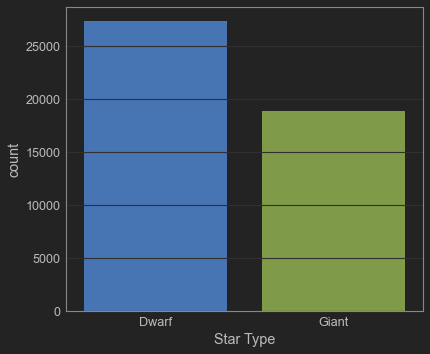

In [81]:
jtplot.style(theme='monokai')
sns.countplot(x = 'Star Type', data = df_clean )
plt.savefig('Count Stars.jpg', dpi=200)
plt.tight_layout
plt.show()


#### Count of Stars Type

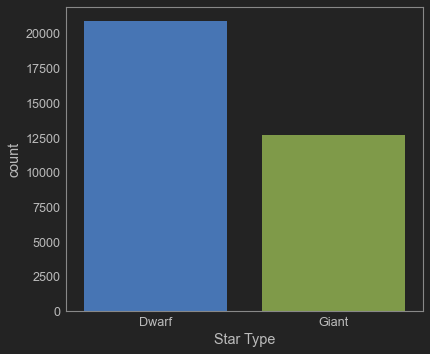

In [82]:
jtplot.style(theme='monokai', gridlines='')
sns.countplot(x = 'Star Type', data = df )
plt.savefig('Count Stars.jpg', dpi=200)
plt.tight_layout
plt.show()


#### Box of Star Type by Spectral Type

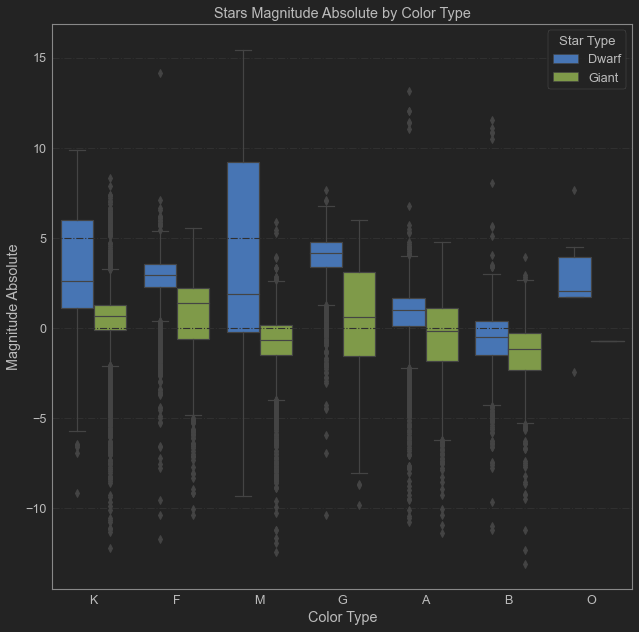

In [83]:
jtplot.style(theme='monokai', gridlines= '-.', figsize=(13,13))
sns.boxplot(data = df_clean,  x = 'Color Type', y = 'Amag', hue = 'Star Type')
plt.xlabel('Color Type')
plt.title('Stars Magnitude Absolute by Color Type')
plt.ylabel('Magnitude Absolute')
plt.savefig('Color Type by Amag.jpg', dpi=200)
plt.tight_layout
plt.show()


#### WITH OUTLIERS Amag by B-V 

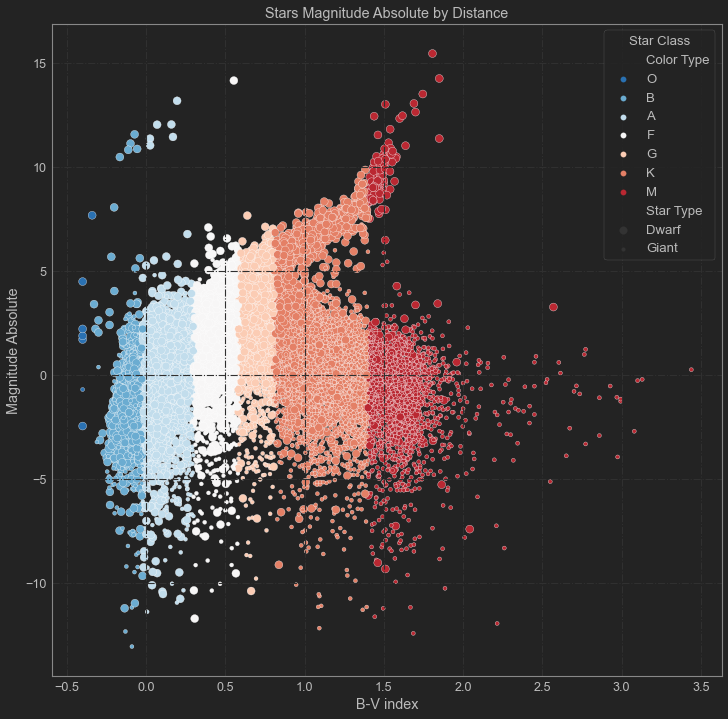

In [84]:
jtplot.style(theme='monokai', gridlines= '-.',figsize=(15,15))

sns.scatterplot(data = df_clean, x = 'B_V', y = 'Amag', hue = 'Color Type', size ='Star Type',
                hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.title('Stars Magnitude Absolute by Distance')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium')

plt.xlabel('B-V index')
plt.ylabel('Magnitude Absolute')

plt.savefig('Clean Magnitude Absolute Color Type LY.jpg', dpi=200)
plt.tight_layout
plt.show()


#### WITH OUTLIERS Vmag by B-V Mag by b-v index

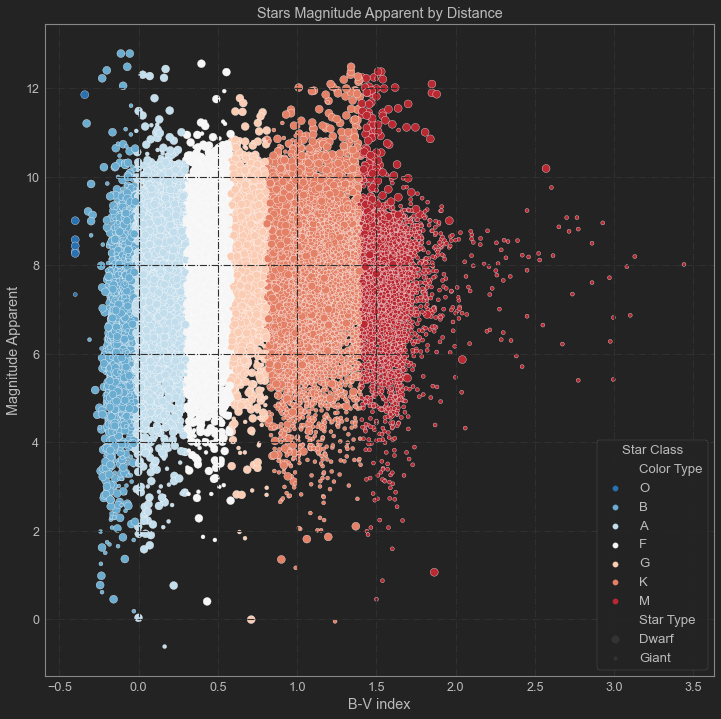

In [85]:
jtplot.style(theme='monokai', gridlines= '-.',figsize=(15,15))

sns.scatterplot(data = df_clean, x = 'B_V', y = 'Vmag', hue = 'Color Type', size ='Star Type',
                hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.title('Stars Magnitude Apparent by Distance')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium')

plt.xlabel('B-V index')
plt.ylabel('Magnitude Apparent')

plt.savefig('Clean Magnitude Apparent Color Type LY.jpg', dpi=200)
plt.tight_layout
plt.show()


#### Luminosity (Sun = 1)  x Mass(Sun=1)  

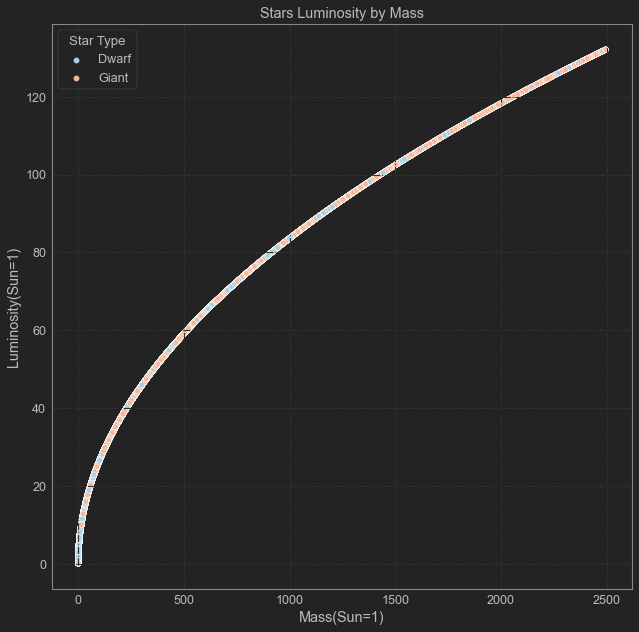

In [86]:
# we can see that bigegr the mass of star in comparation
# with the sun, higher luminosity the star will have
jtplot.style(theme='monokai', gridlines= '-.', figsize=(13,13))

sns.scatterplot(data = df, x = 'Mass(Sun=1)', y = 'Luminosity(Sun=1)', hue = 'Star Type', 
                palette = "RdBu_r")
#plt.legend(title = 'Star Type', fontsize = 'medium', title_fontsize = 'medium')
plt.title('Stars Luminosity by Mass')
plt.savefig('Luminosity by Mass.jpg', dpi=200)
plt.tight_layout

plt.show()




#### Radius by Luminosity

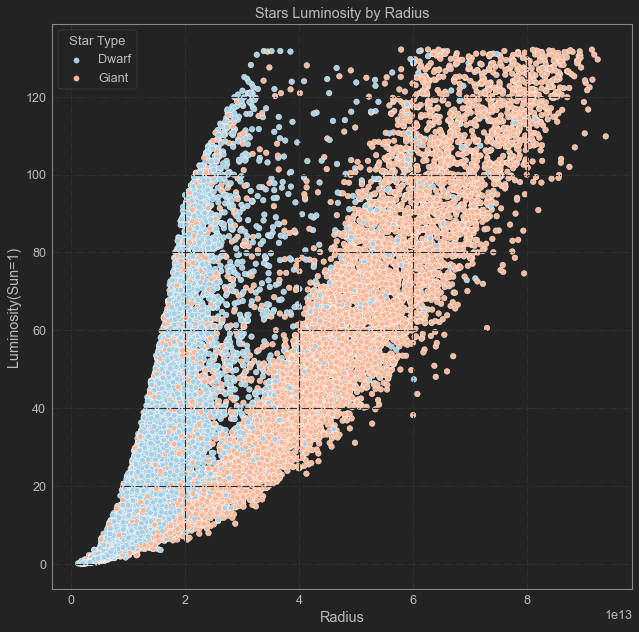

In [87]:
jtplot.style(theme='monokai', gridlines= '-.', figsize=(13,13))

sns.scatterplot(data = df, x = 'Radius', y = 'Luminosity(Sun=1)', hue = 'Star Type', 
                palette = "RdBu_r")
#plt.legend(title = 'Star Type', fontsize = 'medium', title_fontsize = 'medium')
plt.title('Stars Luminosity by Radius')
plt.savefig('Luminosity by Mass.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Mass by Star Type

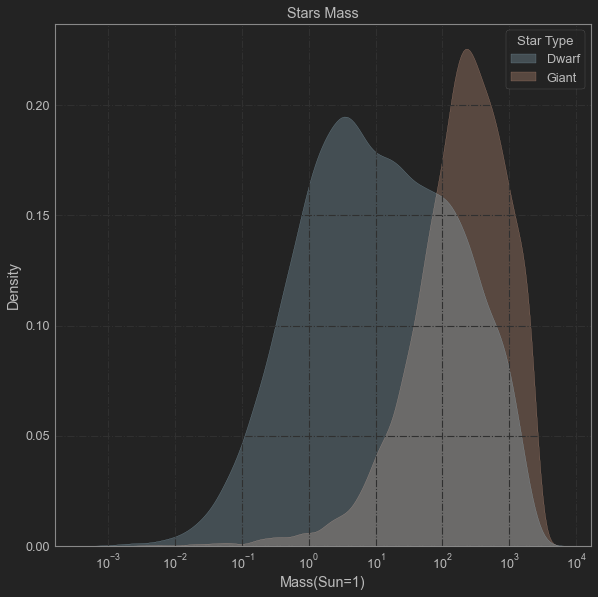

In [88]:
# Giants stars have higher mass

jtplot.style(theme='monokai',gridlines= '-.', figsize=(12,12))

sns.kdeplot(data = df, x = 'Mass(Sun=1)', hue = 'Star Type', palette = "RdBu_r", shade = True, log_scale=10)
plt.title('Stars Mass')
#plt.legend(title = 'Star Type', fontsize = 'medium', title_fontsize = 'medium')

plt.savefig('Stars Mass.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Mass by Radius in relation with the sun

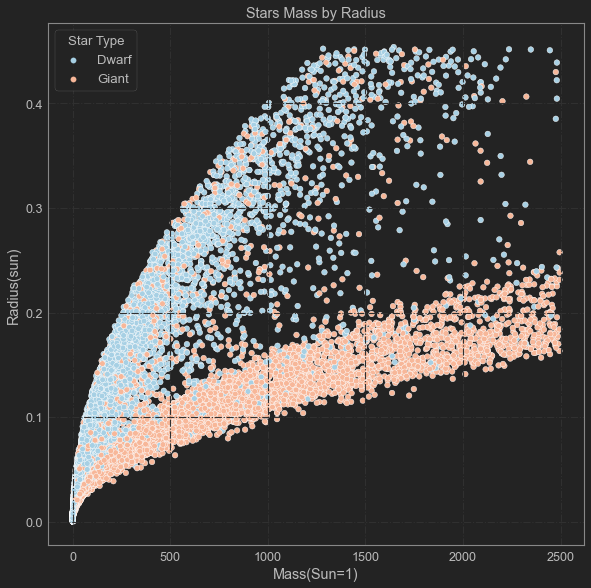

In [89]:
jtplot.style(theme='monokai', gridlines='-.', figsize=(12,12))

sns.scatterplot(data = df, x = 'Mass(Sun=1)', y = 'Radius(sun)', hue = 'Star Type', 
                palette = "RdBu_r")
plt.title('Stars Mass by Radius')
plt.legend(title = 'Star Type', fontsize = 'medium', title_fontsize = 'medium')
plt.savefig('Star Mass by Radius.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Radius by Star Type

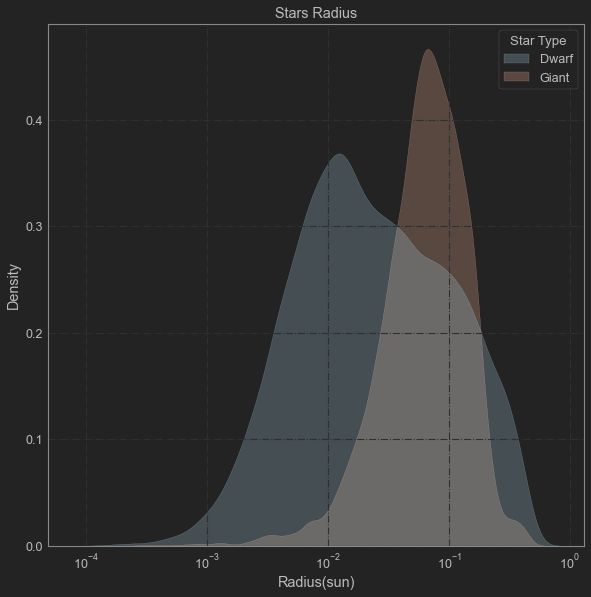

In [90]:
jtplot.style(theme='monokai',gridlines= '-.', figsize=(12,12))

sns.kdeplot(data = df, x = 'Radius(sun)', hue = 'Star Type', palette = "RdBu_r", shade = True, log_scale=10)
plt.title('Stars Radius')
#plt.legend(title = 'Star Type', fontsize = 'medium', title_fontsize = 'medium')

plt.savefig('Stars Radius.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Luminosity by Star Type

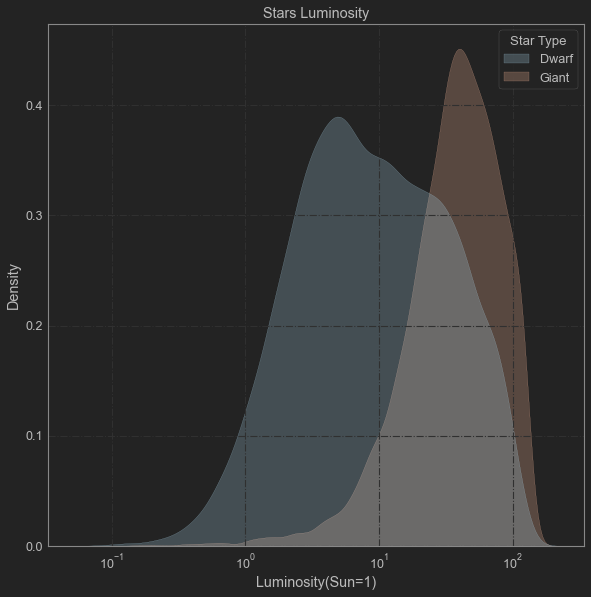

In [91]:
jtplot.style(theme='monokai',gridlines= '-.', figsize=(12,12))

sns.kdeplot(data = df, x = 'Luminosity(Sun=1)', hue = 'Star Type', palette = "RdBu_r", shade = True, log_scale=10)
plt.title('Stars Luminosity')
#plt.legend(title = 'Star Type', fontsize = 'medium', title_fontsize = 'medium')


plt.savefig('Stars Luminosity.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Mag by Luminosity of the Sun

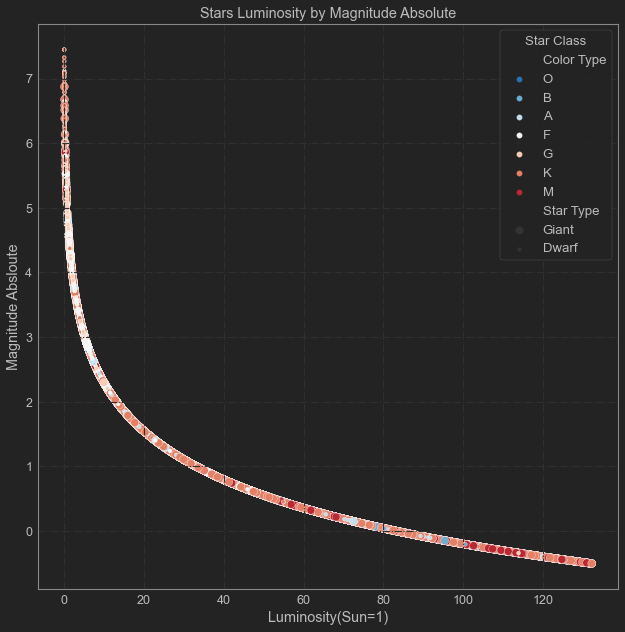

In [92]:
jtplot.style(theme='monokai', gridlines= '-.',figsize=(13,13))

sns.scatterplot(data = df, x = 'Luminosity(Sun=1)', y = 'Amag', hue = 'Color Type', size = 'Star Type', 
                size_order = taille_order, x_bins=3, hue_order = bright_order , palette = "RdBu_r")
plt.title('Stars Luminosity by Magnitude Absolute')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium', bbox_to_anchor=(1, 1))

plt.ylabel('Magnitude Absloute')
plt.savefig('Lum by Amag.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Vmag by Luminosity of the Sun

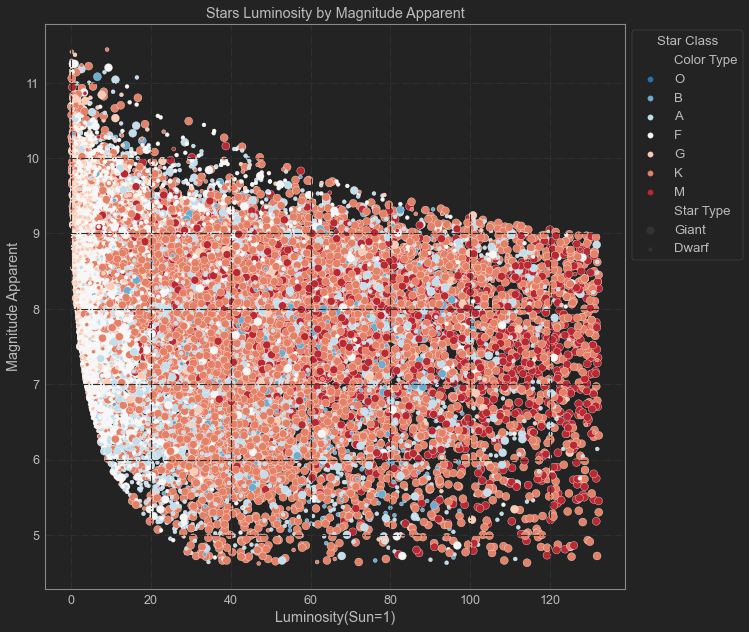

In [93]:
jtplot.style(theme='monokai', gridlines= '-.', figsize=(13,13))

sns.scatterplot(data = df, x = 'Luminosity(Sun=1)', y = 'Vmag', hue = 'Color Type', size = 'Star Type', 
                size_order = taille_order, x_bins=3, hue_order = bright_order , palette = "RdBu_r")
plt.title('Stars Luminosity by Magnitude Apparent')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium', bbox_to_anchor=(1, 1))

plt.ylabel('Magnitude Apparent')
plt.savefig('Lum by Vmag.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Luminosity by B-V index

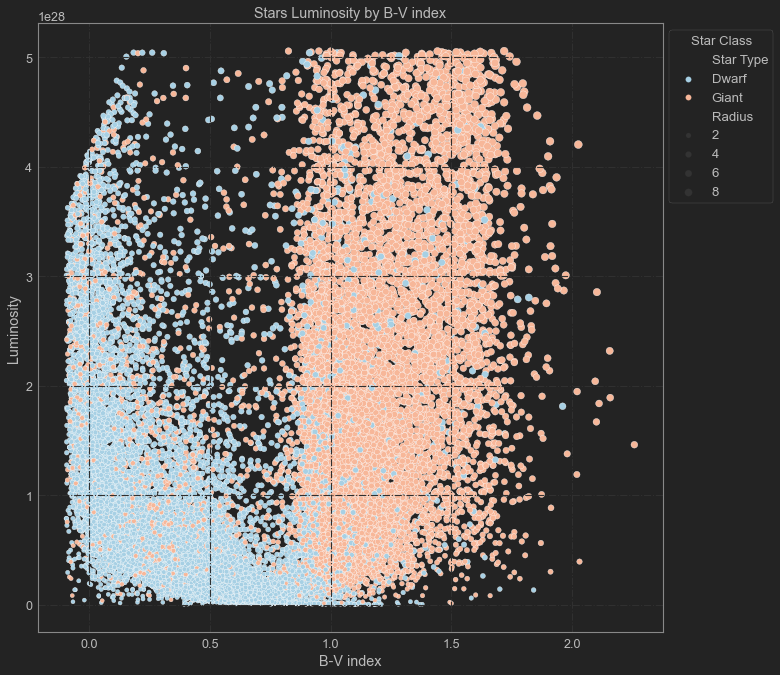

In [94]:
jtplot.style(theme='monokai', gridlines= '-.', figsize=(14,14))
sns.scatterplot(data = df, x = 'B_V', y = 'Luminosity', size = 'Radius', 
                hue = 'Star Type', x_bins=3, palette = "RdBu_r")
plt.title('Stars Luminosity by B-V index')
plt.xlabel('B-V index')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium', bbox_to_anchor=(1, 1))

plt.savefig('Luminosity B_V.jpg', dpi=200)
plt.tight_layout
plt.show()


#### Luminosity by Temperature

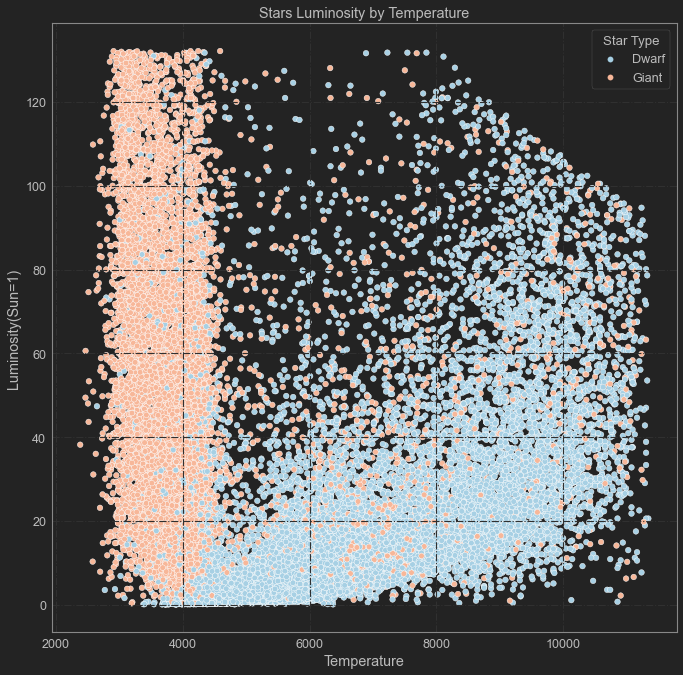

In [95]:
jtplot.style(theme='monokai', gridlines= '-.',figsize=(14,14))

sns.scatterplot(data = df, x = 'Temperature', y = 'Luminosity(Sun=1)', hue = 'Star Type', palette = "RdBu_r")
plt.title('Stars Luminosity by Temperature')

plt.savefig('Temperature by Luminosity.jpg', dpi=200)
plt.tight_layout
plt.show()


#### Light Years by Temp

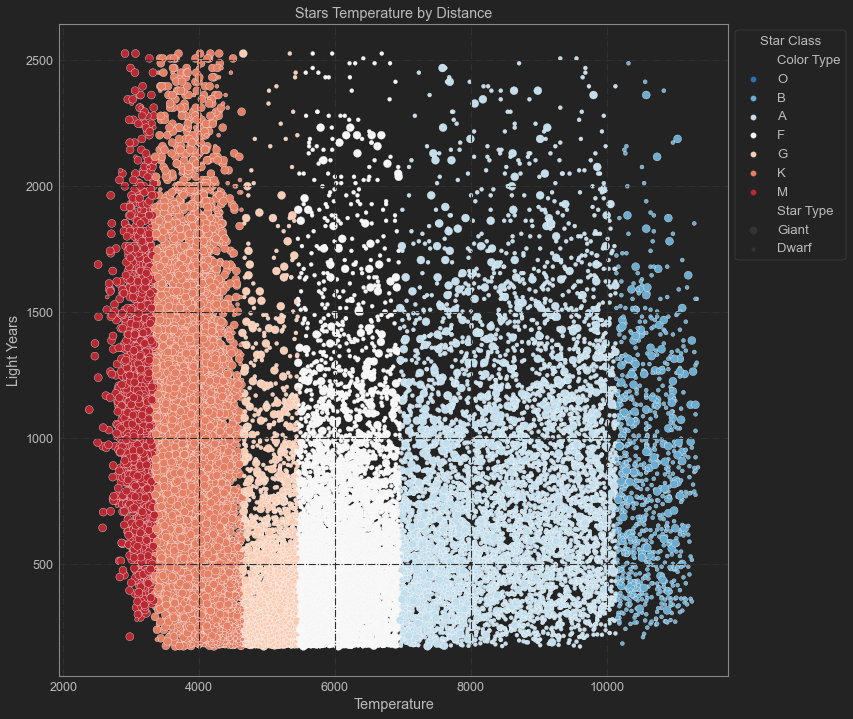

In [96]:
jtplot.style(theme='monokai', gridlines= '-.',figsize=(15,15))
sns.scatterplot(data = df, x = 'Temperature', y = 'ly', hue = 'Color Type', size = 'Star Type', 
                size_order = taille_order, x_bins=3, hue_order = bright_order , palette = "RdBu_r")
plt.title('Stars Temperature by Distance')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium', bbox_to_anchor=(1, 1))

plt.ylabel('Light Years')
plt.savefig('Temperature in Light Years.jpg', dpi=200)
plt.tight_layout

plt.show()



#### Temp by Mass

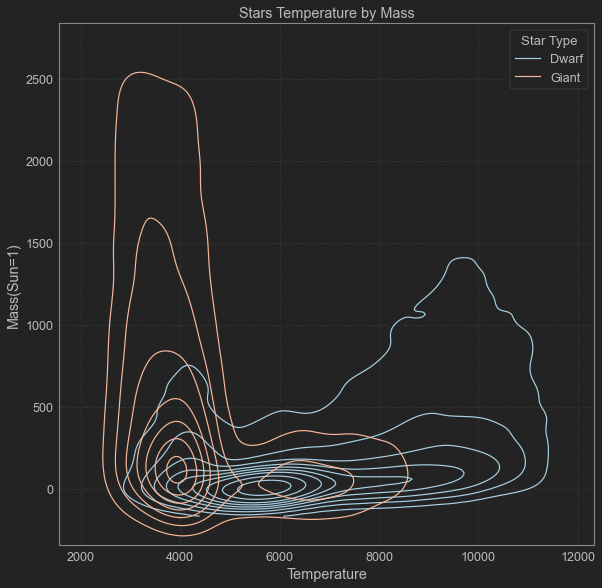

In [97]:
jtplot.style(theme='monokai',gridlines= '-.', figsize=(12,12))
sns.kdeplot(data = df, x = 'Temperature', y = 'Mass(Sun=1)', hue = 'Star Type', palette = "RdBu_r")
plt.title('Stars Temperature by Mass')
plt.savefig('Temperature by Mass.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Temp by Radius

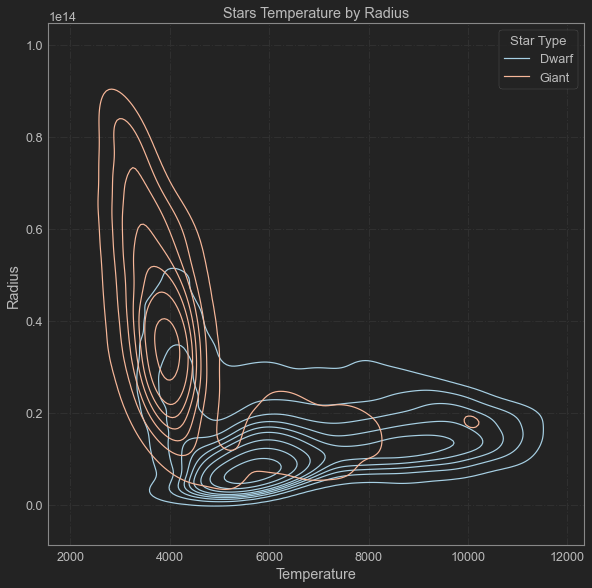

In [98]:
jtplot.style(theme='monokai', gridlines= '-.', figsize=(12,12))
sns.kdeplot(data = df, x = 'Temperature', y = 'Radius', hue = 'Star Type', palette = "RdBu_r")
plt.title('Stars Temperature by Radius')

plt.savefig('Temperature by Radius.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Temp by b_V index

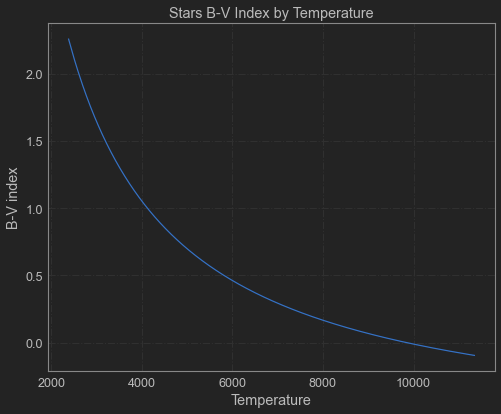

In [99]:
jtplot.style(theme='monokai', gridlines= '-.', figsize=(10,8))
sns.lineplot(data = df, x = 'Temperature', y = 'B_V', palette = "RdBu_r")
plt.title('Stars B-V Index by Temperature')
plt.ylabel('B-V index')
plt.savefig('Temperature B_V.jpg', dpi=200)
plt.tight_layout
plt.show()


#### Temp by Luminosity

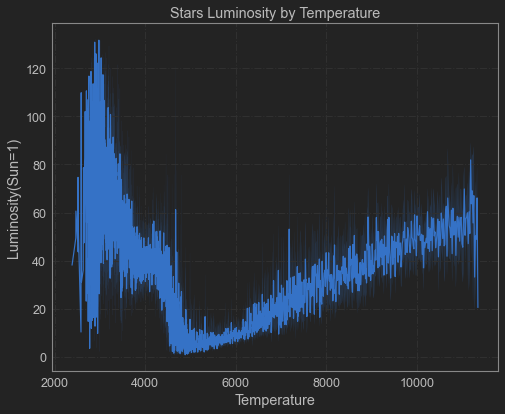

In [100]:
jtplot.style(theme='monokai',gridlines= '-.',  figsize=(10,8))
sns.lineplot(data = df, x = 'Temperature', y = 'Luminosity(Sun=1)', palette = "RdBu_r")
plt.title('Stars Luminosity by Temperature')
plt.savefig('Temperature in Luminosity.jpg', dpi=200)
plt.tight_layout
plt.show()


```python
jtplot.style(theme='monokai', gridlines= '-.', figsize=(10,8) )

sns.lineplot(data = df, x = 'Luminosity(Sun=1)', y = 'B_V', palette = "RdBu_r")
plt.tight_layout
plt.show()

```

#### Luminosity by Light Years 

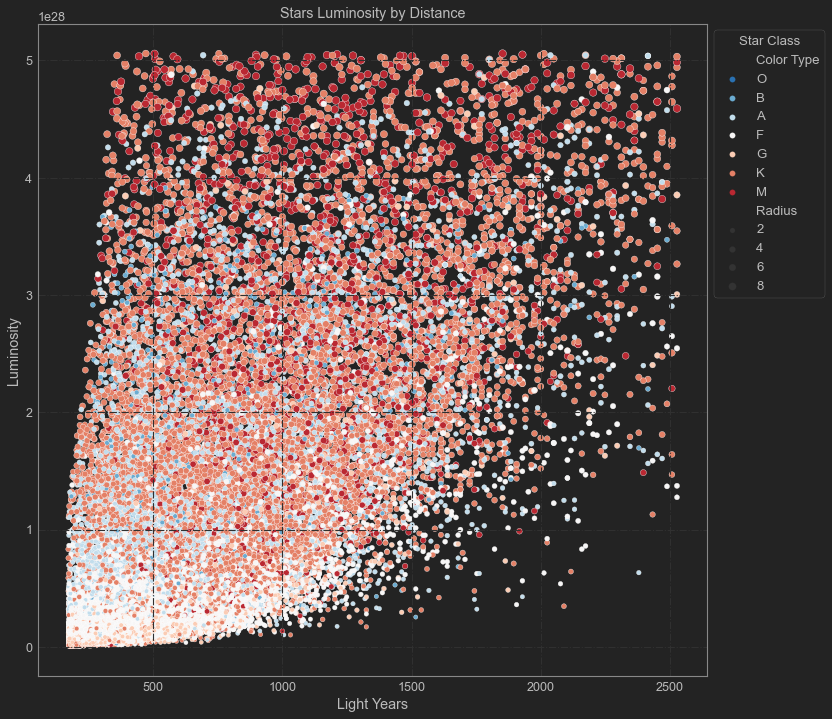

In [101]:
jtplot.style(theme='monokai',gridlines= '-.',  figsize=(15,15))
sns.scatterplot(data = df, x = 'ly', y = 'Luminosity', hue = 'Color Type', size ='Radius',
                hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.grid('-.')
plt.title('Stars Luminosity by Distance')
plt.xlabel('Light Years')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium', bbox_to_anchor=(1, 1))

plt.savefig('Luminosity Color Type LY.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Vmag by Light Years

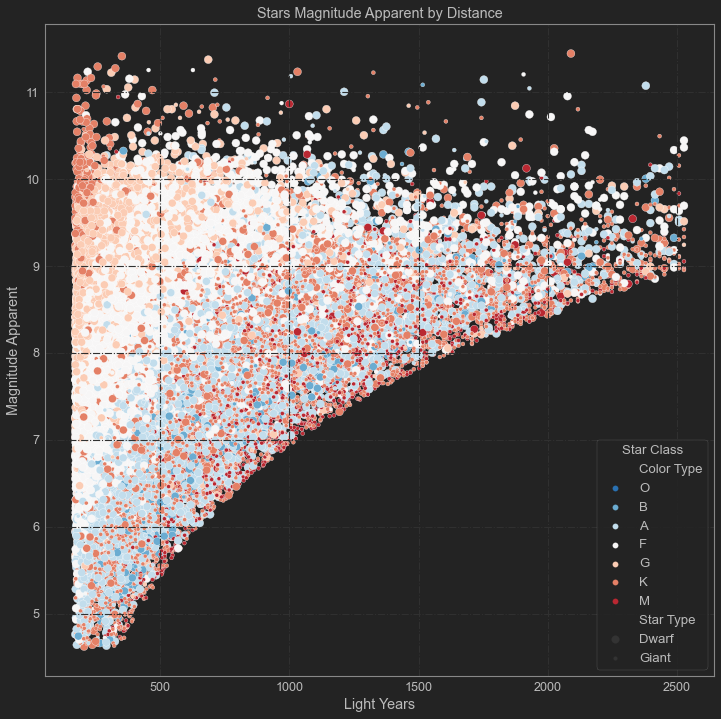

In [102]:
jtplot.style(theme='monokai',gridlines= '-.',  figsize=(15,15))
sns.scatterplot(data = df, x = 'ly', y = 'Vmag', hue = 'Color Type', size ='Star Type',
                hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.title('Stars Magnitude Apparent by Distance')

plt.xlabel('Light Years')
plt.ylabel('Magnitude Apparent')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium')

plt.savefig('Magnitude Apparent Color Type LY.jpg', dpi=200)
plt.tight_layout

plt.show()


#### Amag  by Light Years

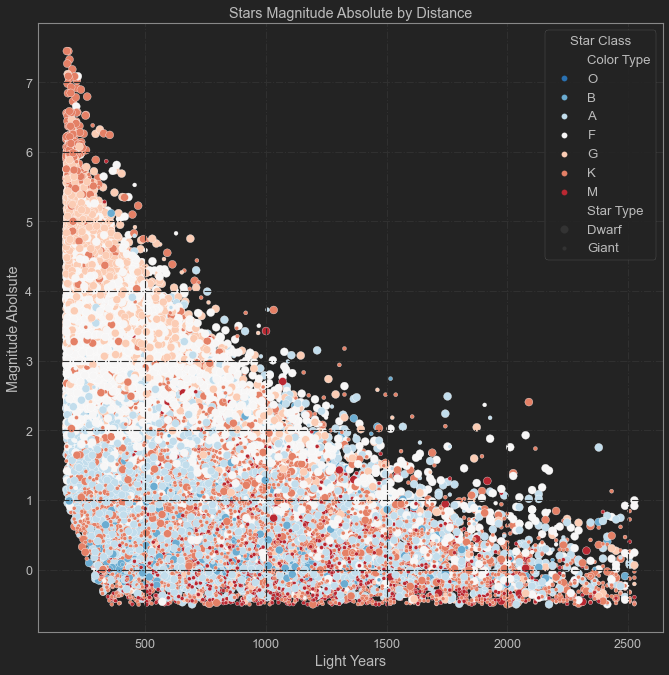

In [103]:
jtplot.style(theme='monokai', gridlines= '-.', figsize=(14,14))
sns.scatterplot(data = df, x = 'ly', y = 'Amag', hue = 'Color Type', size ='Star Type',
                hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.title('Stars Magnitude Absolute by Distance')

plt.xlabel('Light Years')
plt.ylabel('Magnitude Abolsute')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium')

plt.savefig('Magnitude Absolute Color Type LY.jpg', dpi=200)
plt.tight_layout

plt.show()


#### WITH OUTLIERS AMag by LY

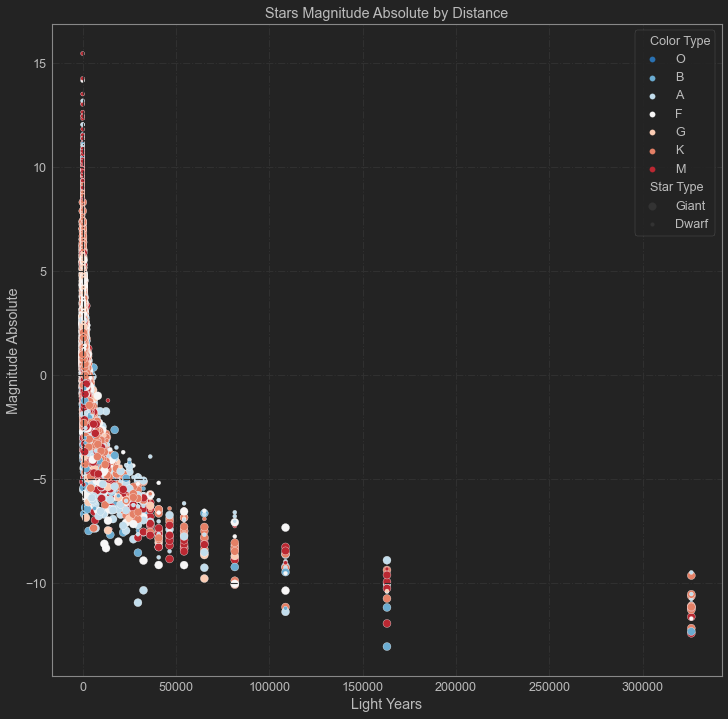

In [104]:
jtplot.style(theme='monokai', gridlines= '-.', figsize=(15,15))
sns.scatterplot(data = df_clean, x = 'ly', y = 'Amag', hue = 'Color Type', size ='Star Type',
                size_order= taille_order, hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.title('Stars Magnitude Absolute by Distance')
plt.xlabel('Light Years')
plt.ylabel('Magnitude Absolute')

plt.savefig('Clean Magnitude Absolute Color Type LY.jpg', dpi=200)
plt.tight_layout


plt.show()


#### WITH OUTLIERS VMag by LY

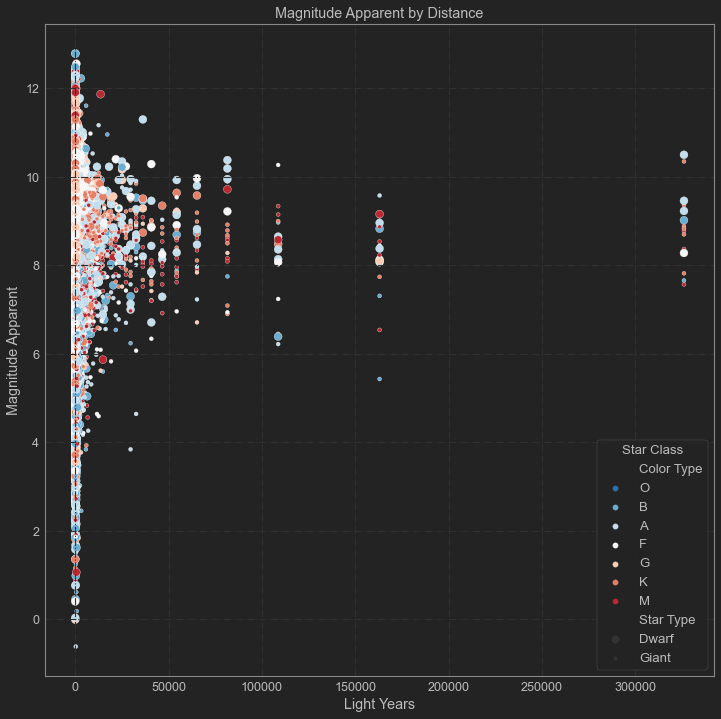

In [105]:
jtplot.style(theme='monokai',gridlines= '-.',  figsize=(15,15))
sns.scatterplot(data = df_clean, x = 'ly', y = 'Vmag', hue = 'Color Type', size ='Star Type',
                hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.grid('-.')
plt.title('Magnitude Apparent by Distance')
plt.legend(title = 'Star Class', fontsize = 'medium', title_fontsize = 'medium')
plt.xlabel('Light Years')
plt.ylabel('Magnitude Apparent')

plt.savefig('Clean Magnitude Apparent Color Type LY.jpg', dpi=200)
plt.tight_layout

plt.show()


In [106]:
df.head()

df_clean.rename(columns={'Color Type': 'Color_Type'}, inplace=True)
df_clean.rename(columns={'Star Type': 'Star_Type'}, inplace = True)

df.rename(columns={'Color Type': 'Color_Type'}, inplace=True)
df.rename(columns={'Star Type': 'Star_Type'}, inplace = True)

## Get dummies

#### Let's create a boolean column for our star type 

In [107]:
df['Target'] = np.where(df.Star_Type == 'Giant', 0,1)

In [108]:
df.Target.value_counts()

1    20876
0    12672
Name: Target, dtype: int64

Giants = 0

Dwarf = 1

#### Should we balance the data ?

In [109]:
# separate the label 
df_giants = df.query('Target == 0').shape[0]
df_dwarf = df.query('Target == 1').shape[0]

In [110]:
print(f'The proportion of the dwarf datapoints is: {round(df_dwarf/df.shape[0],2)*100}%' )
print(f'And the giant datapoints is : {round(df_giants/df.shape[0],2)*100}%')

The proportion of the dwarf datapoints is: 62.0%
And the giant datapoints is : 38.0%


#### Seeing their 2/3 proportion...it's not really essential to balanced it

#### but if we want we can do it:

In [111]:
# Numbers of rows of Giants and Dwarfs

#num_of_giant = df_giants.shape[0]
#num_of_dwarf = df_dwarfs.shape[0]
#print("Giants(0):",num_of_giant)
#print("Dwarfs(1):",num_of_dwarf)

In [112]:
# Downsample majority class
#df_dwarfs_balanced = resample(df_dwarfs, 
                                 #replace=False,    # sample without replacement
                                 #n_samples=num_of_giant,     # to match minority class
                                 #random_state=1) # reproducible results
 
#Combine minority class with downsampled majority class
#df_balanced = pd.concat([df_dwarfs_balanced, df_giants])

In [113]:
#df_balanced.Target.value_counts()

In [114]:
#df = df_balanced 

### Let's see the correlation

<AxesSubplot:>

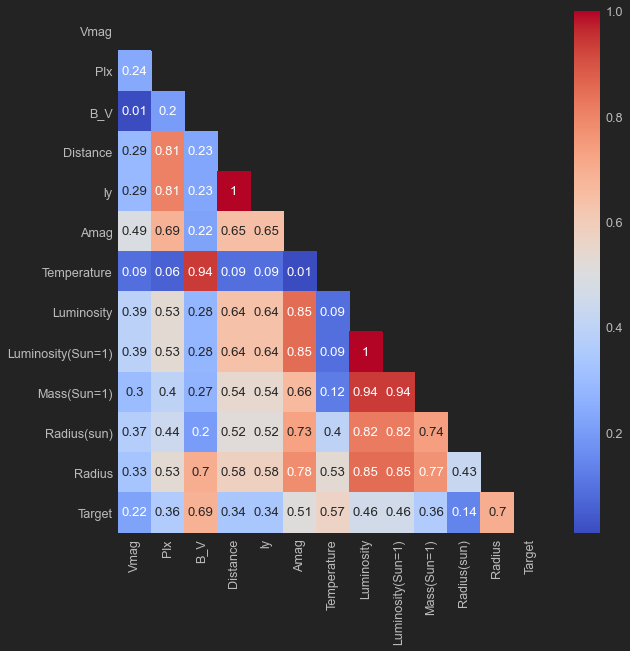

In [115]:
### Heatmap to see the corr between the columns

corr_matrix = df.corr().abs().round(2)
jtplot.style(theme='monokai', figsize=(12,12))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)

#### Dropping high correleted columns 

In [116]:
# Luminosity has at least 3 places with multicollinearity

df.drop('Luminosity', axis = 1, inplace = True)

<AxesSubplot:>

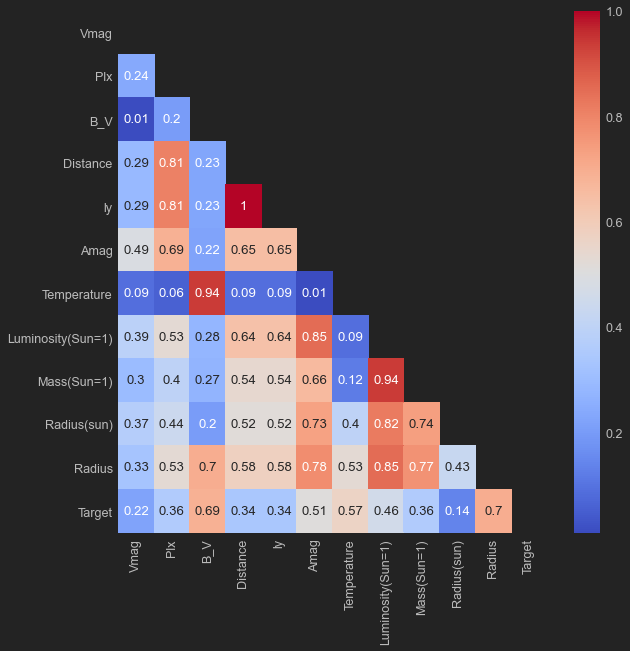

In [117]:
### Let's see the corr between the columns

corr_matrix = df.corr().abs().round(2)
jtplot.style(theme='monokai', figsize=(12,12))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)

In [118]:
# Luminosity(Sun) also has high multicollinearity

df.drop('Luminosity(Sun=1)', axis = 1, inplace = True)


<AxesSubplot:>

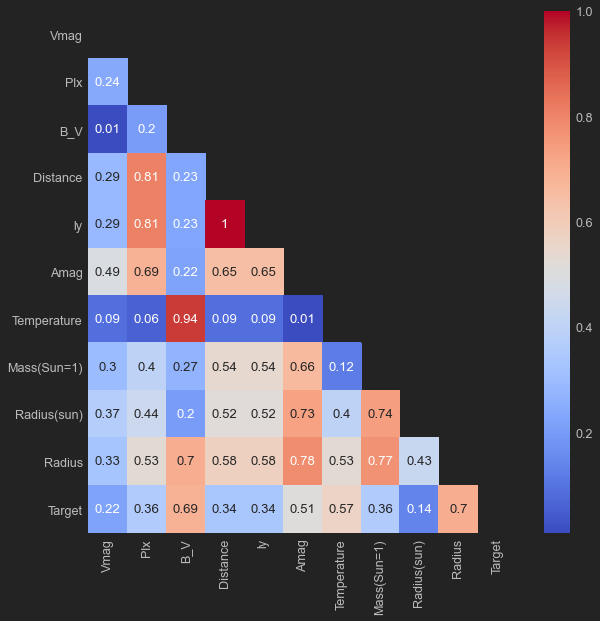

In [119]:
### Let's see the corr between the columns

corr_matrix = df.corr().abs().round(2)
jtplot.style(theme='monokai', figsize=(12,12))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)

In [120]:
# Temperature has high collinearity

df.drop('Temperature', axis = 1, inplace = True)

<AxesSubplot:>

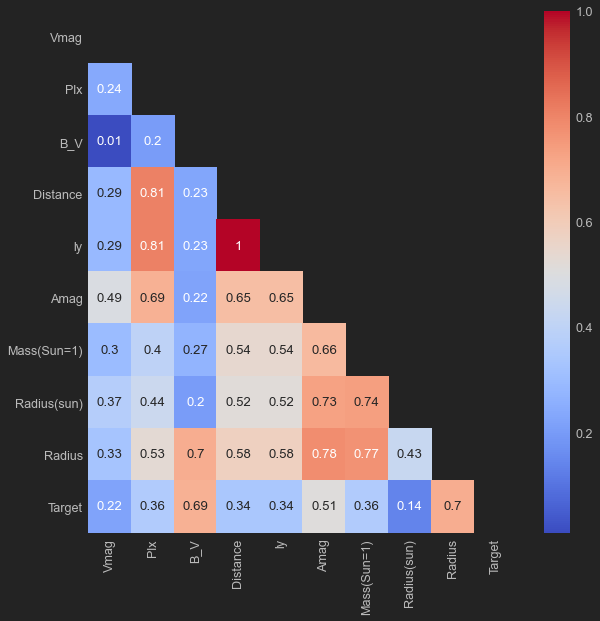

In [121]:
### Let's see the corr between the columns

corr_matrix = df.corr().abs().round(2)
jtplot.style(theme='monokai', figsize=(12,12))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)

In [122]:
# At last we can drop it

df.drop('Distance', axis = 1, inplace = True)

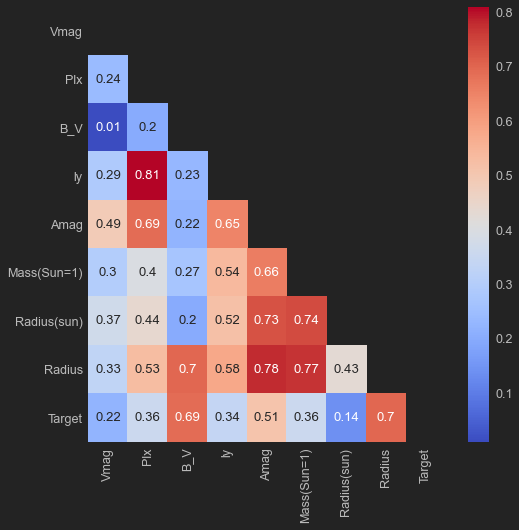

In [123]:
### Let's see the corr between the columns

corr_matrix = df.corr().abs().round(2)
jtplot.style(theme='monokai', figsize=(10,10))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)
plt.show()

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33548 entries, 0 to 33547
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vmag         33548 non-null  float32
 1   Plx          33548 non-null  float64
 2   e_Plx        33548 non-null  object 
 3   B_V          33548 non-null  float32
 4   SpType       33548 non-null  object 
 5   ly           33548 non-null  float64
 6   Amag         33548 non-null  float64
 7   Mass(Sun=1)  33548 non-null  float64
 8   Radius(sun)  33548 non-null  float64
 9   Radius       33548 non-null  float64
 10  Star_Type    33548 non-null  object 
 11  Color_Type   33548 non-null  object 
 12  Target       33548 non-null  int32  
dtypes: float32(2), float64(6), int32(1), object(4)
memory usage: 2.9+ MB


#### The SpType columns has too many uniques values and is too big to get dummies

So lets drop it 

In [125]:
df.drop('SpType', axis = 1, inplace = True)

In [126]:
df.drop('Star_Type', axis = 1, inplace = True)

#### Converting object type

In [127]:
df_dummy = pd.get_dummies(data = df, columns = ['Color_Type'])

In [128]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33548 entries, 0 to 33547
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vmag          33548 non-null  float32
 1   Plx           33548 non-null  float64
 2   e_Plx         33548 non-null  object 
 3   B_V           33548 non-null  float32
 4   ly            33548 non-null  float64
 5   Amag          33548 non-null  float64
 6   Mass(Sun=1)   33548 non-null  float64
 7   Radius(sun)   33548 non-null  float64
 8   Radius        33548 non-null  float64
 9   Target        33548 non-null  int32  
 10  Color_Type_A  33548 non-null  uint8  
 11  Color_Type_B  33548 non-null  uint8  
 12  Color_Type_F  33548 non-null  uint8  
 13  Color_Type_G  33548 non-null  uint8  
 14  Color_Type_K  33548 non-null  uint8  
 15  Color_Type_M  33548 non-null  uint8  
dtypes: float32(2), float64(6), int32(1), object(1), uint8(6)
memory usage: 2.4+ MB


In [129]:
df_dummy.head()

Vmag      Plx   e_Plx    B_V           ly      Amag  Mass(Sun=1)  \
0  8.06  0.00775    0.97  0.370   420.645179  2.506509     9.765509   
1  8.55  0.00287    1.11  0.902  1135.888594  0.839409   210.559268   
2  8.59  0.01076    1.10  0.489   302.973984  3.749061     0.990040   
3  8.43  0.00406    1.16  1.484   802.955709  1.472630    65.583966   
4  8.80  0.00349    1.48  1.128   934.097457  1.514127    60.757538   

   Radius(sun)        Radius  Target  Color_Type_A  Color_Type_B  \
0     0.022850  1.021937e+13       1             0             0   
1     0.071303  3.276937e+13       0             0             0   
2     0.006559  6.396070e+12       1             0             0   
3     0.029286  3.326478e+13       0             0             0   
4     0.033618  2.736376e+13       0             0             0   

   Color_Type_F  Color_Type_G  Color_Type_K  Color_Type_M  
0             1             0             0             0  
1             0             0             1             0  
2             1             0             0             0  
3             0             0             0             1  
4             0             0             1             0

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#### Splitting my test and train 

In [131]:
X_train, X_test, y_train, y_test = train_test_split(df_dummy.drop('Target', axis = 1),
                                                   df_dummy.Target, test_size = 1/5,
                                                   random_state = 42,
                                                   stratify = df.Target)

#### Standard Scaling our data

In [132]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [133]:
X_train_scaled = scaler.transform(X_train)

In [134]:
X_test_scaled = scaler.transform(X_test)

#### Let's create a function to display the confusion matrix 

In [135]:
def cf_matrix(cf_matrix, model_name):
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{value_1}\n\n{value_2}\n\n{value_3}" for value_1, value_2, value_3 
          in zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    fig = plt.figure(figsize=(4, 4))
    sns.set(font_scale=1) 
    cmap = sns.color_palette('vlag', as_cmap=True)


    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=cmap)
    plt.title(model_name, fontweight='bold', fontsize=15, fontname = 'candara')

    fig.tight_layout()
    return plt.show()

#### Logistic Regression

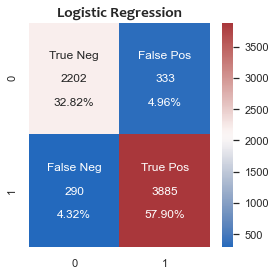

Accuracy score is : 90.72%
Precision score is : 92.11%
Recall score is : 93.05%
F1 score is :92.58%


In [184]:
model_logistic = LogisticRegression(max_iter = 1e5)

model_logistic.fit(X_train_scaled, y_train)


y_pred1 = model_logistic.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred1), 'Logistic Regression' )

print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred1)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred1)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred1)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred1)))
plt.show()

#### Decision Tree

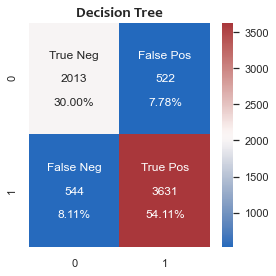

Accuracy score is : 84.11%
Precision score is : 87.43%
Recall score is : 86.97%
F1 score is :87.20%


In [137]:
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train_scaled, y_train)
y_pred2 = model_tree.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred2), 'Decision Tree')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred2)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred2)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred2)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred2)))


<AxesSubplot:>

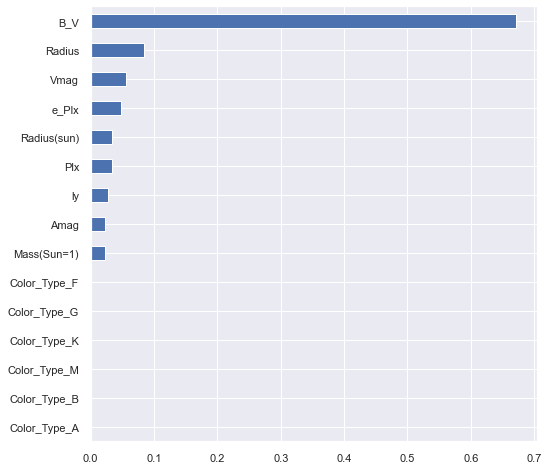

In [138]:
pd.Series(model_tree.feature_importances_, index = X_train.columns).sort_values().plot.barh()

#### KNN

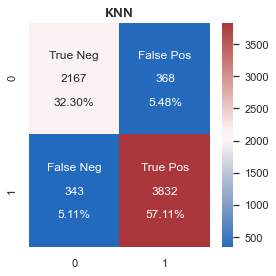

Accuracy score is : 89.40%
Precision score is : 91.24%
Recall score is : 91.78%
F1 score is :91.51%


In [139]:
model_knn = KNeighborsClassifier(5, weights = 'distance')
model_knn.fit(X_train_scaled, y_train)

y_pred3 = model_knn.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred3), 'KNN')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred3)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred3)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred3)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred3)))


#### SVC

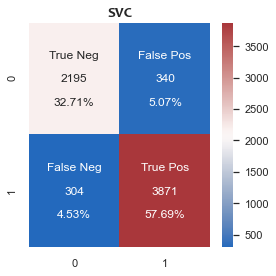

Accuracy score is : 90.40%
Precision score is : 91.93%
Recall score is : 92.72%
F1 score is :92.32%


In [140]:
model_svc = SVC()
model_svc.fit(X_train_scaled, y_train)
y_pred4 = model_svc.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred4), 'SVC')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred4)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred4)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred4)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred4)))


#### Gaussian NB

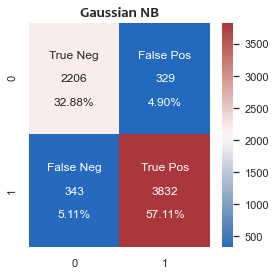

Accuracy score is : 89.99%
Precision score is : 92.09%
Recall score is : 91.78%
F1 score is :91.94%


In [141]:
model_NB = GaussianNB()
model_NB.fit(X_train_scaled, y_train)
y_pred5 = model_NB.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred5), 'Gaussian NB')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred5)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred5)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred5)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred5)))


#### Random Forest

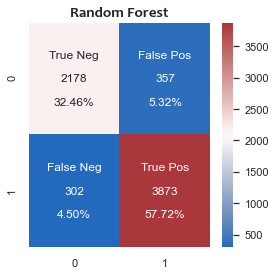

Accuracy score is : 90.18%
Precision score is : 91.56%
Recall score is : 92.77%
F1 score is :92.16%


In [142]:
model_rf = RandomForestClassifier(class_weight='balanced')
model_rf.fit(X_train_scaled, y_train)
y_pred6 = model_rf.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred6), 'Random Forest')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred6)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred6)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred6)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred6)))


<AxesSubplot:>

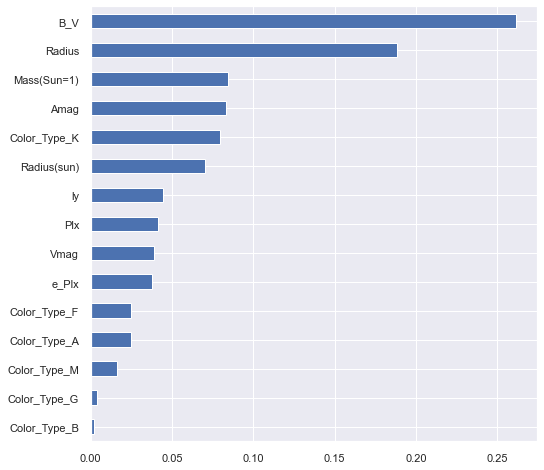

In [143]:
pd.Series(model_rf.feature_importances_, index = X_train.columns).sort_values().plot.barh()

#### AdaBoost

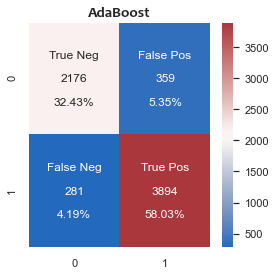

Accuracy score is : 90.46%
Precision score is : 91.56%
Recall score is : 93.27%
F1 score is :92.41%


In [144]:
model_ad = AdaBoostClassifier()
model_ad.fit(X_train_scaled, y_train)
y_pred7 = model_ad.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred7), 'AdaBoost')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred7)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred7)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred7)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred7)))



<AxesSubplot:>

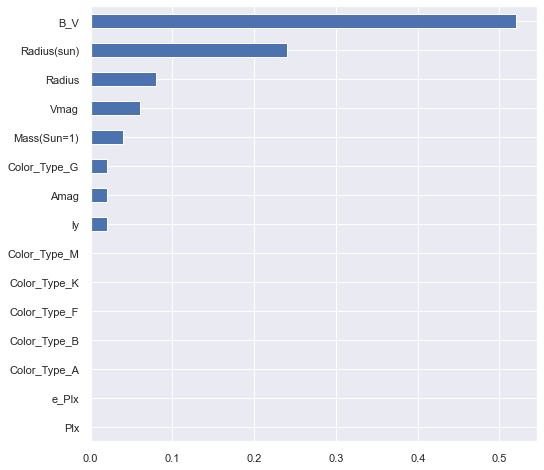

In [145]:
pd.Series(model_ad.feature_importances_, index = X_train.columns).sort_values().plot.barh()

#### XGBoost

C:\Users\bruna\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


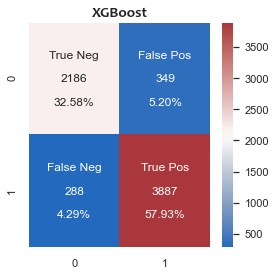

Accuracy score is : 90.51%
Precision score is : 91.76%
Recall score is : 93.10%
F1 score is :92.43%


In [146]:
model_xg = XGBClassifier()
model_xg.fit(X_train_scaled, y_train)
y_pred8 = model_xg.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred8), 'XGBoost')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred8)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred8)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred8)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred8)))


<AxesSubplot:>

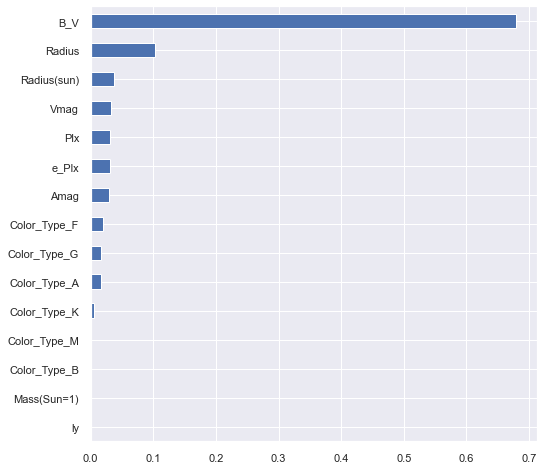

In [147]:
pd.Series(model_xg.feature_importances_, index = X_train.columns).sort_values().plot.barh()

#### LightGBM

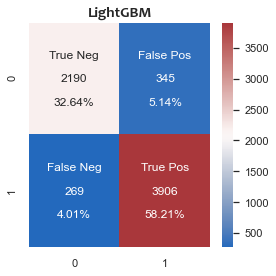

Accuracy score is : 90.85%
Precision score is : 91.88%
Recall score is : 93.56%
F1 score is :92.71%


In [148]:
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_train_scaled, y_train)
y_pred9 = model_lgbm.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred9), 'LightGBM')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred9)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred9)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred9)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred9)))


In [149]:
X_train.rename(columns = {'B_V': 'B-V'}, inplace = True)
X_train.rename(columns = {'e_Plx': 'Plx StdError'}, inplace = True)
X_train.rename(columns = {'ly': 'Light Years'}, inplace = True)
X_train.rename(columns = {'Color_Type_F': 'Color Type F'}, inplace = True)
X_train.rename(columns = {'Color_Type_G': 'Color Type G'}, inplace = True)
X_train.rename(columns = {'Color_Type_A': 'Color Type A'}, inplace = True)
X_train.rename(columns = {'Color_Type_M': 'Color Type M'}, inplace = True)
X_train.rename(columns = {'Color_Type_K': 'Color Type K'}, inplace = True)
X_train.rename(columns = {'Color_Type_B': 'Color Type B'}, inplace = True)

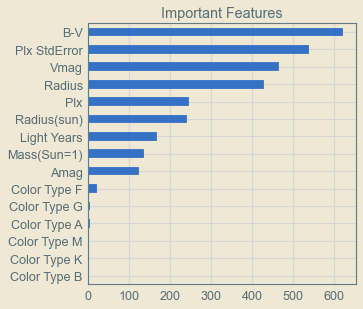

In [150]:
jtplot.style(theme='solarizedl', figsize=(6,6))

pd.Series(model_lgbm.feature_importances_, index = X_train.columns).sort_values().plot.barh()
plt.title('Important Features')
plt.savefig('Important Features.jpg', dpi=200)
plt.tight_layout

plt.show()


#### CatBoost

In [151]:
model_cat=CatBoostClassifier()
model_cat.fit(X_train_scaled, y_train)
y_pred10 = model_cat.predict(X_test_scaled)


Learning rate set to 0.041977
0:	learn: 0.6515335	total: 221ms	remaining: 3m 40s
1:	learn: 0.6140721	total: 238ms	remaining: 1m 58s
2:	learn: 0.5812011	total: 258ms	remaining: 1m 25s
3:	learn: 0.5507808	total: 276ms	remaining: 1m 8s
4:	learn: 0.5245883	total: 298ms	remaining: 59.3s
5:	learn: 0.4999647	total: 315ms	remaining: 52.3s
6:	learn: 0.4786612	total: 335ms	remaining: 47.5s
7:	learn: 0.4599642	total: 353ms	remaining: 43.8s
8:	learn: 0.4430266	total: 376ms	remaining: 41.4s
9:	learn: 0.4277438	total: 402ms	remaining: 39.8s
10:	learn: 0.4143280	total: 425ms	remaining: 38.2s
11:	learn: 0.4020917	total: 445ms	remaining: 36.6s
12:	learn: 0.3912490	total: 463ms	remaining: 35.2s
13:	learn: 0.3813013	total: 487ms	remaining: 34.3s
14:	learn: 0.3727431	total: 505ms	remaining: 33.2s
15:	learn: 0.3648308	total: 525ms	remaining: 32.3s
16:	learn: 0.3575867	total: 543ms	remaining: 31.4s
17:	learn: 0.3509181	total: 566ms	remaining: 30.9s
18:	learn: 0.3449685	total: 595ms	remaining: 30.7s
19:	lear

163:	learn: 0.2655792	total: 3.81s	remaining: 19.4s
164:	learn: 0.2655066	total: 3.82s	remaining: 19.3s
165:	learn: 0.2654379	total: 3.85s	remaining: 19.3s
166:	learn: 0.2653914	total: 3.87s	remaining: 19.3s
167:	learn: 0.2653241	total: 3.89s	remaining: 19.2s
168:	learn: 0.2653010	total: 3.91s	remaining: 19.2s
169:	learn: 0.2652634	total: 3.93s	remaining: 19.2s
170:	learn: 0.2652171	total: 3.96s	remaining: 19.2s
171:	learn: 0.2651829	total: 3.97s	remaining: 19.1s
172:	learn: 0.2650951	total: 4.01s	remaining: 19.2s
173:	learn: 0.2650024	total: 4.04s	remaining: 19.2s
174:	learn: 0.2649644	total: 4.08s	remaining: 19.2s
175:	learn: 0.2648735	total: 4.1s	remaining: 19.2s
176:	learn: 0.2647967	total: 4.11s	remaining: 19.1s
177:	learn: 0.2647295	total: 4.13s	remaining: 19.1s
178:	learn: 0.2646737	total: 4.15s	remaining: 19s
179:	learn: 0.2646114	total: 4.18s	remaining: 19s
180:	learn: 0.2645696	total: 4.2s	remaining: 19s
181:	learn: 0.2644950	total: 4.23s	remaining: 19s
182:	learn: 0.2644525	

326:	learn: 0.2561066	total: 7.18s	remaining: 14.8s
327:	learn: 0.2560656	total: 7.21s	remaining: 14.8s
328:	learn: 0.2560203	total: 7.23s	remaining: 14.7s
329:	learn: 0.2559654	total: 7.25s	remaining: 14.7s
330:	learn: 0.2559143	total: 7.26s	remaining: 14.7s
331:	learn: 0.2558563	total: 7.28s	remaining: 14.7s
332:	learn: 0.2557986	total: 7.3s	remaining: 14.6s
333:	learn: 0.2557330	total: 7.32s	remaining: 14.6s
334:	learn: 0.2556739	total: 7.34s	remaining: 14.6s
335:	learn: 0.2556067	total: 7.36s	remaining: 14.5s
336:	learn: 0.2555272	total: 7.38s	remaining: 14.5s
337:	learn: 0.2554649	total: 7.4s	remaining: 14.5s
338:	learn: 0.2554073	total: 7.42s	remaining: 14.5s
339:	learn: 0.2553234	total: 7.44s	remaining: 14.4s
340:	learn: 0.2552847	total: 7.46s	remaining: 14.4s
341:	learn: 0.2552530	total: 7.48s	remaining: 14.4s
342:	learn: 0.2551885	total: 7.49s	remaining: 14.4s
343:	learn: 0.2551293	total: 7.51s	remaining: 14.3s
344:	learn: 0.2551002	total: 7.53s	remaining: 14.3s
345:	learn: 0.

485:	learn: 0.2480434	total: 10.4s	remaining: 11s
486:	learn: 0.2479906	total: 10.4s	remaining: 11s
487:	learn: 0.2479736	total: 10.4s	remaining: 10.9s
488:	learn: 0.2479240	total: 10.4s	remaining: 10.9s
489:	learn: 0.2479040	total: 10.5s	remaining: 10.9s
490:	learn: 0.2478505	total: 10.5s	remaining: 10.9s
491:	learn: 0.2478080	total: 10.5s	remaining: 10.8s
492:	learn: 0.2477486	total: 10.5s	remaining: 10.8s
493:	learn: 0.2477101	total: 10.5s	remaining: 10.8s
494:	learn: 0.2476745	total: 10.6s	remaining: 10.8s
495:	learn: 0.2476085	total: 10.6s	remaining: 10.7s
496:	learn: 0.2475601	total: 10.6s	remaining: 10.7s
497:	learn: 0.2474960	total: 10.6s	remaining: 10.7s
498:	learn: 0.2474570	total: 10.6s	remaining: 10.7s
499:	learn: 0.2474350	total: 10.6s	remaining: 10.6s
500:	learn: 0.2473927	total: 10.7s	remaining: 10.6s
501:	learn: 0.2473457	total: 10.7s	remaining: 10.6s
502:	learn: 0.2473026	total: 10.7s	remaining: 10.6s
503:	learn: 0.2472558	total: 10.7s	remaining: 10.6s
504:	learn: 0.24

651:	learn: 0.2403072	total: 13.7s	remaining: 7.3s
652:	learn: 0.2402716	total: 13.7s	remaining: 7.28s
653:	learn: 0.2402489	total: 13.7s	remaining: 7.26s
654:	learn: 0.2401972	total: 13.7s	remaining: 7.23s
655:	learn: 0.2401358	total: 13.8s	remaining: 7.21s
656:	learn: 0.2400906	total: 13.8s	remaining: 7.19s
657:	learn: 0.2400031	total: 13.8s	remaining: 7.17s
658:	learn: 0.2399559	total: 13.8s	remaining: 7.15s
659:	learn: 0.2398883	total: 13.8s	remaining: 7.13s
660:	learn: 0.2398341	total: 13.8s	remaining: 7.1s
661:	learn: 0.2398232	total: 13.9s	remaining: 7.08s
662:	learn: 0.2398005	total: 13.9s	remaining: 7.06s
663:	learn: 0.2397528	total: 13.9s	remaining: 7.04s
664:	learn: 0.2396754	total: 13.9s	remaining: 7.02s
665:	learn: 0.2396290	total: 14s	remaining: 7s
666:	learn: 0.2395513	total: 14s	remaining: 6.98s
667:	learn: 0.2395019	total: 14s	remaining: 6.96s
668:	learn: 0.2394658	total: 14s	remaining: 6.93s
669:	learn: 0.2394004	total: 14s	remaining: 6.91s
670:	learn: 0.2393556	total

816:	learn: 0.2331289	total: 16.9s	remaining: 3.78s
817:	learn: 0.2330816	total: 16.9s	remaining: 3.76s
818:	learn: 0.2330498	total: 16.9s	remaining: 3.74s
819:	learn: 0.2330097	total: 16.9s	remaining: 3.72s
820:	learn: 0.2329887	total: 17s	remaining: 3.7s
821:	learn: 0.2329475	total: 17s	remaining: 3.68s
822:	learn: 0.2329207	total: 17s	remaining: 3.65s
823:	learn: 0.2328583	total: 17s	remaining: 3.63s
824:	learn: 0.2328181	total: 17s	remaining: 3.61s
825:	learn: 0.2327781	total: 17s	remaining: 3.59s
826:	learn: 0.2327550	total: 17.1s	remaining: 3.57s
827:	learn: 0.2327270	total: 17.1s	remaining: 3.55s
828:	learn: 0.2326823	total: 17.1s	remaining: 3.53s
829:	learn: 0.2326074	total: 17.1s	remaining: 3.51s
830:	learn: 0.2325467	total: 17.2s	remaining: 3.49s
831:	learn: 0.2325018	total: 17.2s	remaining: 3.47s
832:	learn: 0.2324715	total: 17.2s	remaining: 3.44s
833:	learn: 0.2324222	total: 17.2s	remaining: 3.42s
834:	learn: 0.2323856	total: 17.2s	remaining: 3.4s
835:	learn: 0.2323400	tota

978:	learn: 0.2264712	total: 20s	remaining: 429ms
979:	learn: 0.2264376	total: 20s	remaining: 409ms
980:	learn: 0.2264029	total: 20.1s	remaining: 388ms
981:	learn: 0.2263432	total: 20.1s	remaining: 368ms
982:	learn: 0.2262792	total: 20.1s	remaining: 347ms
983:	learn: 0.2262438	total: 20.1s	remaining: 327ms
984:	learn: 0.2262089	total: 20.1s	remaining: 307ms
985:	learn: 0.2262002	total: 20.1s	remaining: 286ms
986:	learn: 0.2261655	total: 20.2s	remaining: 266ms
987:	learn: 0.2261380	total: 20.2s	remaining: 245ms
988:	learn: 0.2261191	total: 20.2s	remaining: 225ms
989:	learn: 0.2260895	total: 20.2s	remaining: 204ms
990:	learn: 0.2260620	total: 20.2s	remaining: 184ms
991:	learn: 0.2260099	total: 20.3s	remaining: 163ms
992:	learn: 0.2259838	total: 20.3s	remaining: 143ms
993:	learn: 0.2259591	total: 20.3s	remaining: 123ms
994:	learn: 0.2259331	total: 20.3s	remaining: 102ms
995:	learn: 0.2258978	total: 20.3s	remaining: 81.7ms
996:	learn: 0.2258722	total: 20.4s	remaining: 61.2ms
997:	learn: 0.

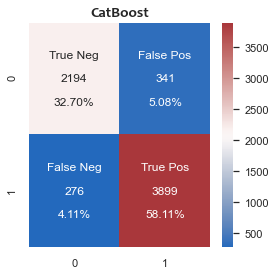

Accuracy score is : 90.80%
Precision score is : 91.96%
Recall score is : 93.39%
F1 score is :92.67%


In [183]:


cf_matrix(confusion_matrix(y_test, y_pred10), 'CatBoost')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred10)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred10)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred10)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred10)))
plt.show()

#### Gradient Boosting for classification

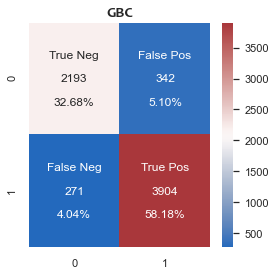

Accuracy score is : 90.86%
Precision score is : 91.95%
Recall score is : 93.51%
F1 score is :92.72%


In [153]:
model_gbc = GradientBoostingClassifier()
model_gbc.fit(X_train_scaled, y_train)
y_pred11 = model_gbc.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred11), 'GBC')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred11)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred11)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred11)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred11)))


<AxesSubplot:>

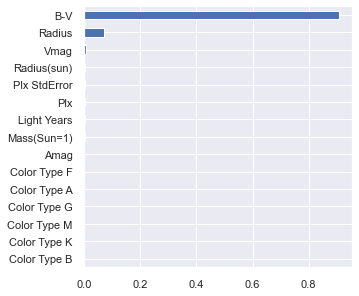

In [154]:
pd.Series(model_gbc.feature_importances_, index = X_train.columns).sort_values().plot.barh()

### Summary

In [155]:
a, p, r, f = [], [], [], []
for model in [model_logistic, model_tree, model_knn, model_svc, model_NB, model_rf, model_ad, model_xg, model_lgbm, model_gbc]:
    a.append(accuracy_score(y_test, model.predict(X_test_scaled)))
    p.append(precision_score(y_test, model.predict(X_test_scaled)))
    r.append(recall_score(y_test, model.predict(X_test_scaled)))
    f.append(f1_score(y_test, model.predict(X_test_scaled)))

In [156]:
model_score = pd.DataFrame([a, p, r, f], columns = ['LR', 'DT', 'KNN', 'SVC', 'NB', 'RF', 'AB', 'XGB', 'LGBM', 'GBC']).T.sort_values(
    by=3, ascending = False).rename(columns = {0: 'Accurancy',
                                              1: 'Precision',
                                              2: 'Recall',
                                              3: 'F1'})

model_score

Accurancy  Precision    Recall        F1
GBC    0.908644   0.919454  0.935090  0.927206
LGBM   0.908495   0.918843  0.935569  0.927130
LR     0.907154   0.921053  0.930539  0.925771
XGB    0.905067   0.917611  0.931018  0.924266
AB     0.904620   0.915589  0.932695  0.924063
SVC    0.904024   0.919259  0.927186  0.923205
RF     0.901788   0.915603  0.927665  0.921594
NB     0.899851   0.920932  0.917844  0.919386
KNN    0.894039   0.912381  0.917844  0.915104
DT     0.841133   0.874308  0.869701  0.871998

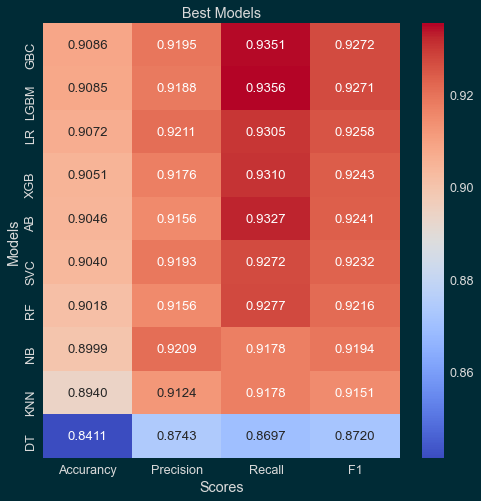

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [157]:
jtplot.style(theme='solarizedd', figsize=(10,10))
sns.heatmap(model_score, annot=True, cmap = 'coolwarm', fmt = '0.4f' )
plt.title('Best Models')
plt.xlabel('Scores')
plt.ylabel('Models')

plt.savefig('Models Comp.jpg', dpi=200)
plt.show()
plt.tight_layout

In [158]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, roc_curve


TP = True Positive – The model predicted the positive class correctly, to be a positive class.

FP = False Positive – The model predicted the negative class incorrectly, to be a positive class.

FN = False Negative – The model predicted the positive class incorrectly, to be the negative class.

TN = True Negative – The model predicted the negative class correctly, to be the negative class

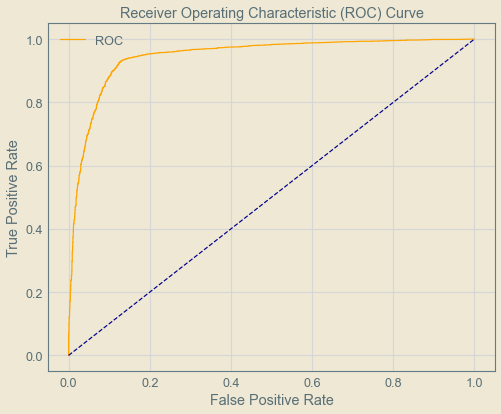

<Figure size 576x460.8 with 0 Axes>

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [181]:
fpr, tpr, thresholds = roc_curve(y_test, model_lgbm.predict_proba(X_test_scaled)[:,1])

jtplot.style(theme='solarizedl', figsize=(10,8))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
plt.savefig('ROC.jpg', dpi=200)
plt.show()
plt.tight_layout

In [160]:
roc_auc_score(y_test, model_lgbm.predict_proba(X_test_scaled)[:,1])


0.9461400985012224

In [161]:
from sklearn.metrics import log_loss
log_loss(y_test, model_lgbm.predict_proba(X_test_scaled)[:,1])

0.27187973215818556

In [162]:
model_lgbm.predict_proba(X_test_scaled)[:,1]

array([0.03702702, 0.82161915, 0.09801285, ..., 0.98848278, 0.99024659,
       0.97970816])

In [163]:
model_lgbm.predict_proba(X_test_scaled)[:,1]

array([0.03702702, 0.82161915, 0.09801285, ..., 0.98848278, 0.99024659,
       0.97970816])

In [164]:
model_lgbm.predict(X_test_scaled)

array([0, 1, 0, ..., 1, 1, 1])

In [165]:
from pycaret.classification import *
cl = setup(data=df_dummy, target='Target')


In [185]:
best = compare_models()

In [167]:
lgbm = create_model('lightgbm')

In [168]:
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

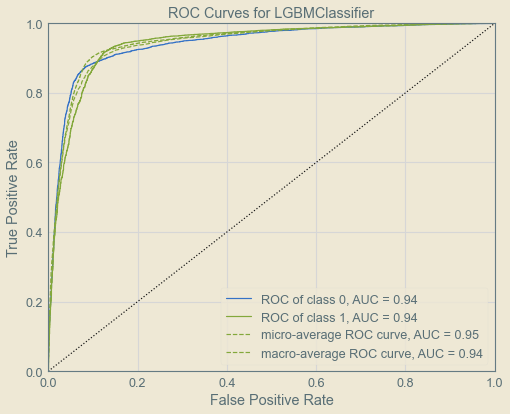

In [169]:
# AUC plot
jtplot.style(theme='solarizedl', figsize=(10,8))

plot_model(lgbm, plot = 'auc')
plt.tight_layout
plt.show()


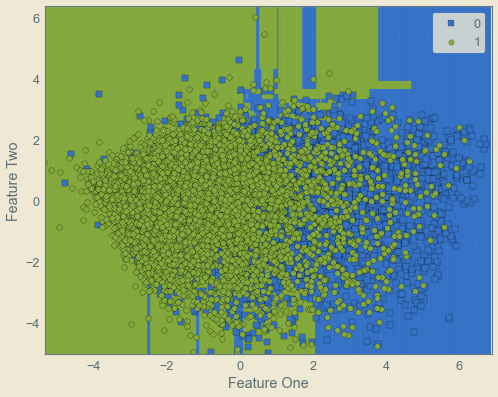

In [170]:
# Decision Boundary
jtplot.style(theme='solarizedl', figsize=(10,8))

plot_model(lgbm, plot = 'boundary')
plt.tight_layout
plt.show()



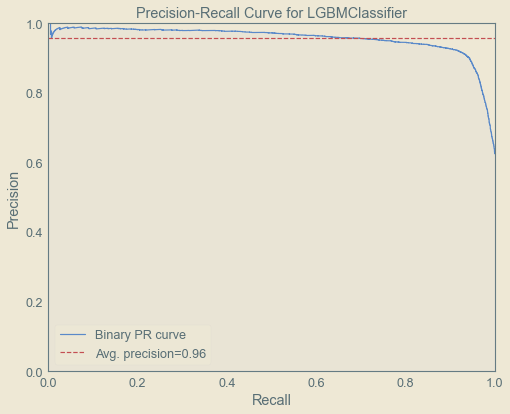

<Figure size 576x460.8 with 0 Axes>

In [171]:
# Precision Recall Curve
jtplot.style(theme='solarizedl', figsize=(10,8))

plot_model(lgbm, plot = 'pr')

plt.savefig('Precision-Recall.jpg', dpi=200)
plt.tight_layout
plt.show()


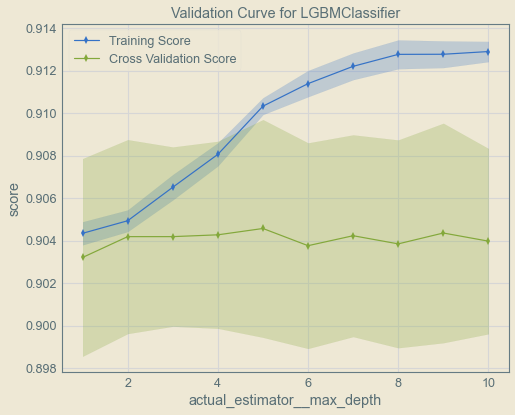

<Figure size 576x460.8 with 0 Axes>

In [172]:
# Validation Curve
jtplot.style(theme='solarizedl', figsize=(10,8))

plot_model(lgbm, plot = 'vc')
plt.savefig('Validation Curve.jpg', dpi=200)
plt.tight_layout

plt.show()


In [173]:
from sklearn.cluster import KMeans

In [174]:
from yellowbrick.cluster import KElbowVisualizer

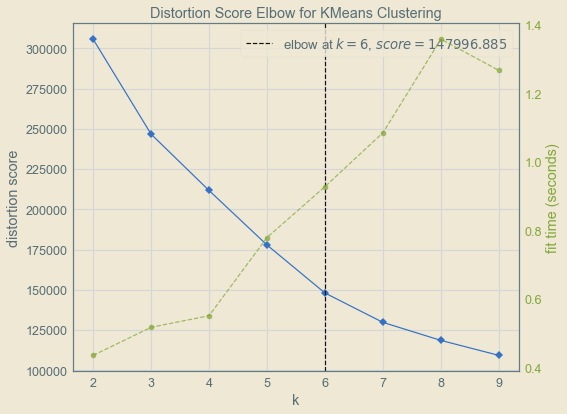

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [175]:
model = KMeans()

jtplot.style(theme='solarizedl', figsize=(10,8))

visualizer = KElbowVisualizer(model, k = (2,10))

visualizer.fit(X_train_scaled)
visualizer.poof()

## With PCA

In [176]:
from sklearn.decomposition import PCA

In [177]:
pca = PCA(0.85)
pca.fit(df_dummy)

PCA(copy=True, iterated_power='auto', n_components=0.85, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [178]:
df_pca = pca.transform(df_dummy)

In [179]:
df_pca = pd.DataFrame(df_pca, columns=['PC'+str(i) for i in range(1, df_pca.shape[1]+1)])

In [180]:
df_pca

PC1
0     -1.220440e+13
1      1.034561e+13
2     -1.602769e+13
3      1.084102e+13
4      4.939994e+12
...             ...
33543 -8.476235e+12
33544 -1.546876e+13
33545 -4.664664e+11
33546 -3.062389e+12
33547  1.465699e+12

[33548 rows x 1 columns]